In [ ]:
import numpy as np      # np.arrays
import pandas as pd     # dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# Gráficos
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Datas-tempos
import math
from datetime import datetime
from datetime import timedelta

# Outros pacotes se precisar
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
import pmdarima as pm
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

In [ ]:
pd.options.display.max_columns=100           # ver colunas

df_Loja = pd.read_csv('stores.csv')         # dados das lojas
df_Loja.rename(columns={'Type':'Tipo'},inplace=True) # Renomeia coluna
df_Loja.rename(columns={'Size':'Tamanho'},inplace=True) # Renomeia coluna
df_Loja.rename(columns={'Store':'Loja'},inplace=True) # Renomeia coluna
df_Loja.head()

,Loja,Tipo,Tamanho
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
df_train = pd.read_csv('train.csv')          # dados de treino
df_train.rename(columns={'Store':'Loja'},inplace=True) # Renomeia coluna
df_train.rename(columns={'Dept':'Depart'},inplace=True) # Renomeia coluna
df_train.rename(columns={'Date':'Data'},inplace=True) # Renomeia coluna
df_train.rename(columns={'Weekly_Sales':'Venda_Semanal'},inplace=True) # Renomeia coluna
df_train.rename(columns={'IsHoliday':'Feriado'},inplace=True) # Renomeia coluna
df_train.head()

,Loja,Depart,Data,Venda_Semanal,Feriado
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
df_features = pd.read_csv('features.csv')    # informações externas
df_features.rename(columns={'Store':'Loja'},inplace=True) # Renomeia coluna
df_features.rename(columns={'Date':'Data'},inplace=True) # Renomeia coluna
df_features.rename(columns={'Temperature':'Temperatura'},inplace=True) # Renomeia coluna
df_features.rename(columns={'Fuel_Price':'Preco_gasolina'},inplace=True) # Renomeia coluna
df_features.rename(columns={'Temperature':'Temperatura'},inplace=True) # Renomeia coluna
df_features.rename(columns={'Fuel_Price':'Preco_gasolina'},inplace=True) # Renomeia coluna
df_features.rename(columns={'MarkDown1':'Desconto1'},inplace=True) # Renomeia coluna
df_features.rename(columns={'MarkDown2':'Desconto2'},inplace=True) # Renomeia coluna
df_features.rename(columns={'MarkDown3':'Desconto3'},inplace=True) # Renomeia coluna
df_features.rename(columns={'MarkDown4':'Desconto4'},inplace=True) # Renomeia coluna
df_features.rename(columns={'MarkDown5':'Desconto5'},inplace=True) # Renomeia coluna
df_features.rename(columns={'CPI':'IPC'},inplace=True) # Renomeia coluna
df_features.rename(columns={'Unemployment':'Desemprego'},inplace=True) # Renomeia coluna
df_features.rename(columns={'IsHoliday':'Feriado'},inplace=True) # Renomeia coluna
df_features.head()

,Loja,Data,Temperatura,Preco_gasolina,Desconto1,Desconto2,Desconto3,Desconto4,Desconto5,IPC,Desemprego,Feriado
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
# Juntar 3 datasets utilizando inner join (junção de pelos comuns)
df = df_train.merge(df_features, on=['Loja', 'Data'], how='inner').merge(df_Loja, on=['Loja'], how='inner')
df.head(5)

,Loja,Depart,Data,Venda_Semanal,Feriado_x,Temperatura,Preco_gasolina,Desconto1,Desconto2,Desconto3,Desconto4,Desconto5,IPC,Desemprego,Feriado_y,Tipo,Tamanho
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [ ]:
df.drop(['Feriado_y'], axis=1,inplace=True) # Remove coluna duplicada
df.rename(columns={'Feriado_x':'Feriado'},inplace=True) # Renomeia coluna
df.head() # last ready data set

,Loja,Depart,Data,Venda_Semanal,Feriado,Temperatura,Preco_gasolina,Desconto1,Desconto2,Desconto3,Desconto4,Desconto5,IPC,Desemprego,Tipo,Tamanho
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [ ]:
df.shape

(421570, 16)

In [ ]:
######### LIMPEZA DE DADOS: Análise de Lojas e Departamentos #########
df['Loja'].nunique() # conta os valores únicos de Loja: 45

45

In [ ]:
df['Depart'].nunique() # conta os valores únicos de Depart: 81

81

In [ ]:
## Crio tabela pivot que me indica as vendas médias por loja e departamento
loja_depart_table = pd.pivot_table(df, index='Loja', columns='Depart',
                                  values='Venda_Semanal', aggfunc=np.mean)
display(loja_depart_table)

Depart,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Loja,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,

In [ ]:
## a tabela indicou que os departamentos vão de 1 a 99 (???)
# missings entre os departamentos, valores negativos de vendas
# a seguir, eu filtro os valores de vendas semanais menores ou iguais a 0

df.loc[df['Venda_Semanal']<=0]	# seleciona as linhas com valores semanais menores que 0

,Loja,Depart,Data,Venda_Semanal,Feriado,Temperatura,Preco_gasolina,Desconto1,Desconto2,Desconto3,Desconto4,Desconto5,IPC,Desemprego,Tipo,Tamanho
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


In [ ]:
x = (1358*100)/421570     ### Calculo o percentual de valores errados
print(x)

0.3221291837654482


In [ ]:
df = df.loc[df['Venda_Semanal'] > 0]

In [ ]:
df.shape # Novo formato da tabela

(420212, 16)

In [ ]:
######### Análise de Datas #########
pd.concat([df['Data'].head(5), df['Data'].tail(5)]) # ver primeiros e últimos 5

,Data
0,2010-02-05
1,2010-02-05
2,2010-02-05
3,2010-02-05
4,2010-02-05
421565,2012-10-26
421566,2012-10-26
421567,2012-10-26
421568,2012-10-26
421569,2012-10-26


<Axes: xlabel='Feriado', ylabel='Venda_Semanal'>

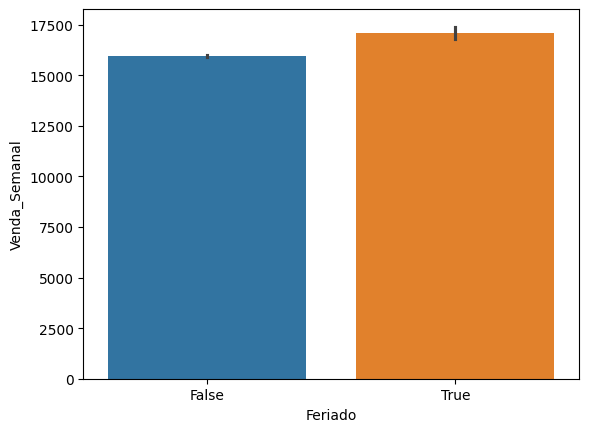

In [ ]:
sns.barplot(x='Feriado', y='Venda_Semanal', hue = 'Feriado', data=df, legend=False)	# Gráfico de barras, feriados por vendas semanais, cores diferentes por barra (hue), sem legendas

In [ ]:
df_holiday = df.loc[df['Feriado']==True]
df_holiday['Data'].unique()		# Crio arranjo de datas únicas, feriados

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [ ]:
df_not_holiday = df.loc[df['Feriado']==False]
df_not_holiday['Data'].nunique()	# Conto o números de datas não-únicas

133

In [ ]:
## Todos os feriados (americanos) não estão nos dados. Existem 4 feriados como:
#Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
#Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
#Ação_de_Graças: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
#Natal: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

#Feriados pós 7/09/12 estão no dateset Test para predição.
#Quando olhamos para a informação, vendas médias semanais em feriados são bem maiores do que em não-feriados.
#Nos dados de treino (Train), existem 133 semanas para não-feriados e 10 para feriados.

#Caso queiramos ver diferenças entre os tipos de feriados, precisamos de outras colunas.
#Crio nova coluna para os 4 tipos de feriados e coloco valores boolean (True, False)
#Se a data pertence a feriado ou não

In [ ]:
# Datas do Super bowl em set de treino
df.loc[(df['Data'] == '2010-02-12')|(df['Data'] == '2011-02-11')|(df['Data'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Data'] != '2010-02-12')&(df['Data'] != '2011-02-11')&(df['Data'] != '2012-02-10'),'Super_Bowl'] = False

In [ ]:
# Datas do Trabalhador em set de treino
df.loc[(df['Data'] == '2010-09-10')|(df['Data'] == '2011-09-09')|(df['Data'] == '2012-09-07'),'Trabalhador'] = True
df.loc[(df['Data'] != '2010-09-10')&(df['Data'] != '2011-09-09')&(df['Data'] != '2012-09-07'),'Trabalhador'] = False

In [ ]:
# Datas de Ação de Graças em set de treino
df.loc[(df['Data'] == '2010-11-26')|(df['Data'] == '2011-11-25'),'Ação_de_Graças'] = True
df.loc[(df['Data'] != '2010-11-26')&(df['Data'] != '2011-11-25'),'Ação_de_Graças'] = False

In [ ]:
# Datas de Natal em set de treino
df.loc[(df['Data'] == '2010-12-31')|(df['Data'] == '2011-12-30'),'Natal'] = True
df.loc[(df['Data'] != '2010-12-31')&(df['Data'] != '2011-12-30'),'Natal'] = False

<Axes: xlabel='Natal', ylabel='Venda_Semanal'>

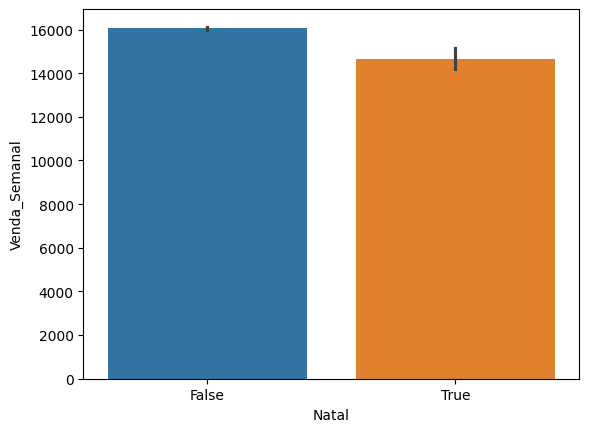

In [ ]:
sns.barplot(x='Natal', y='Venda_Semanal', hue = 'Natal', data=df, legend=False) # Feriado Natal vs Não-Natal

<Axes: xlabel='Ação_de_Graças', ylabel='Venda_Semanal'>

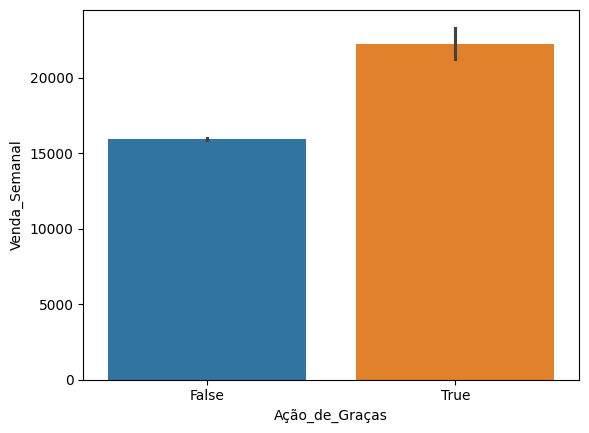

In [ ]:
sns.barplot(x='Ação_de_Graças', y='Venda_Semanal', hue = 'Ação_de_Graças', data=df, legend=False) # Feriado Ação de Graças vs Não-Ação de Graças

<Axes: xlabel='Super_Bowl', ylabel='Venda_Semanal'>

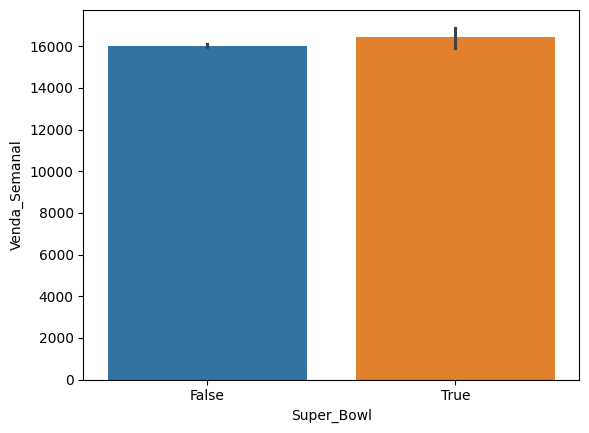

In [ ]:
sns.barplot(x='Super_Bowl', y='Venda_Semanal', hue = 'Super_Bowl', data=df, legend=False) # Feriado Super_Bowl vs Não-Super_Bowl

<Axes: xlabel='Trabalhador', ylabel='Venda_Semanal'>

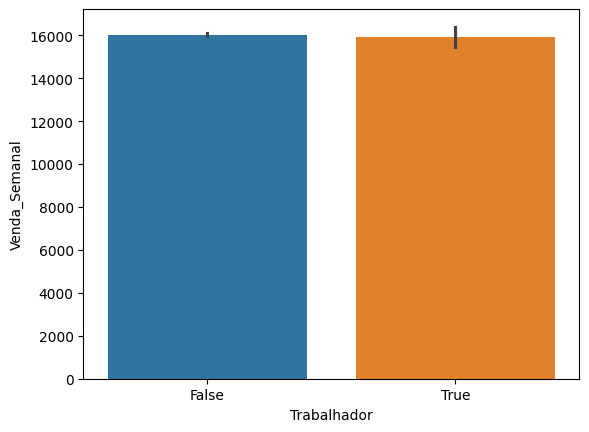

In [ ]:
sns.barplot(x='Trabalhador', y='Venda_Semanal', hue = 'Trabalhador', data=df, legend=False) # Feriado Labor_Day vs Não-Labor_Day

In [ ]:
#Pelos gráficos, Dia do Trabalhador e Natal não necessariamente aumentam vendas semanais.
#Existe efeito positivo em vendas no Super Bowl, mas a maior diferença é na Ação de Graças (pode ser explicado pela Black Friday).

## A seguir a análise de data por tipo de loja ##
df.groupby(['Natal','Tipo'])['Venda_Semanal'].mean()  # Média de vendas semanal para tipos de lojas no Natal

Natal  Tipo
False  A       20174.350209
       B       12301.986116
       C        9570.951973
True   A       18310.167535
       B       11488.988057
       C        8031.520607
Name: Venda_Semanal, dtype: float64

In [ ]:
df.groupby(['Trabalhador','Tipo'])['Venda_Semanal'].mean()  # Média de vendas semanal para tipos de lojas no Dia do Trabalhador

Trabalhador  Tipo
False        A       20151.210941
             B       12294.954138
             C        9542.098293
True         A       20004.267422
             B       12084.304642
             C        9893.459258
Name: Venda_Semanal, dtype: float64

In [ ]:
df.groupby(['Ação_de_Graças','Tipo'])['Venda_Semanal'].mean()  # Média de vendas semanal para tipos de lojas na Ação de Graças

Ação_de_Graças  Tipo
False           A       20044.007801
                B       12197.717405
                C        9547.377807
True            A       27397.776346
                B       18733.973971
                C        9696.566616
Name: Venda_Semanal, dtype: float64

In [ ]:
df.groupby(['Super_Bowl','Tipo'])['Venda_Semanal'].mean()  # Média de vendas semanal para tipos de lojas no Super Bowl

Super_Bowl  Tipo
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Venda_Semanal, dtype: float64

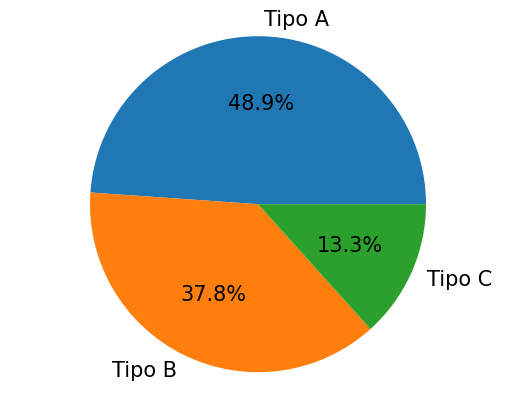

In [ ]:
# Em geral, gráficos de pizza são difíceis de analisar.
# Porém, as diferenças são grandes, então podemos utilizar
# Gráfico em pizza dos percentuais
my_data = [48.88, 37.77 , 13.33 ]  # percentuais
my_labels = 'Tipo A','Tipo B', 'Tipo C' # Títulos
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) # gráfico em pizza com títulos maiores
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) # Maiores percentuais

plt.show()

In [ ]:
# Médias semanais por feriado ou não
df.groupby('Feriado')['Venda_Semanal'].mean()

,Venda_Semanal
Feriado,
False,15952.816352
True,17094.300918


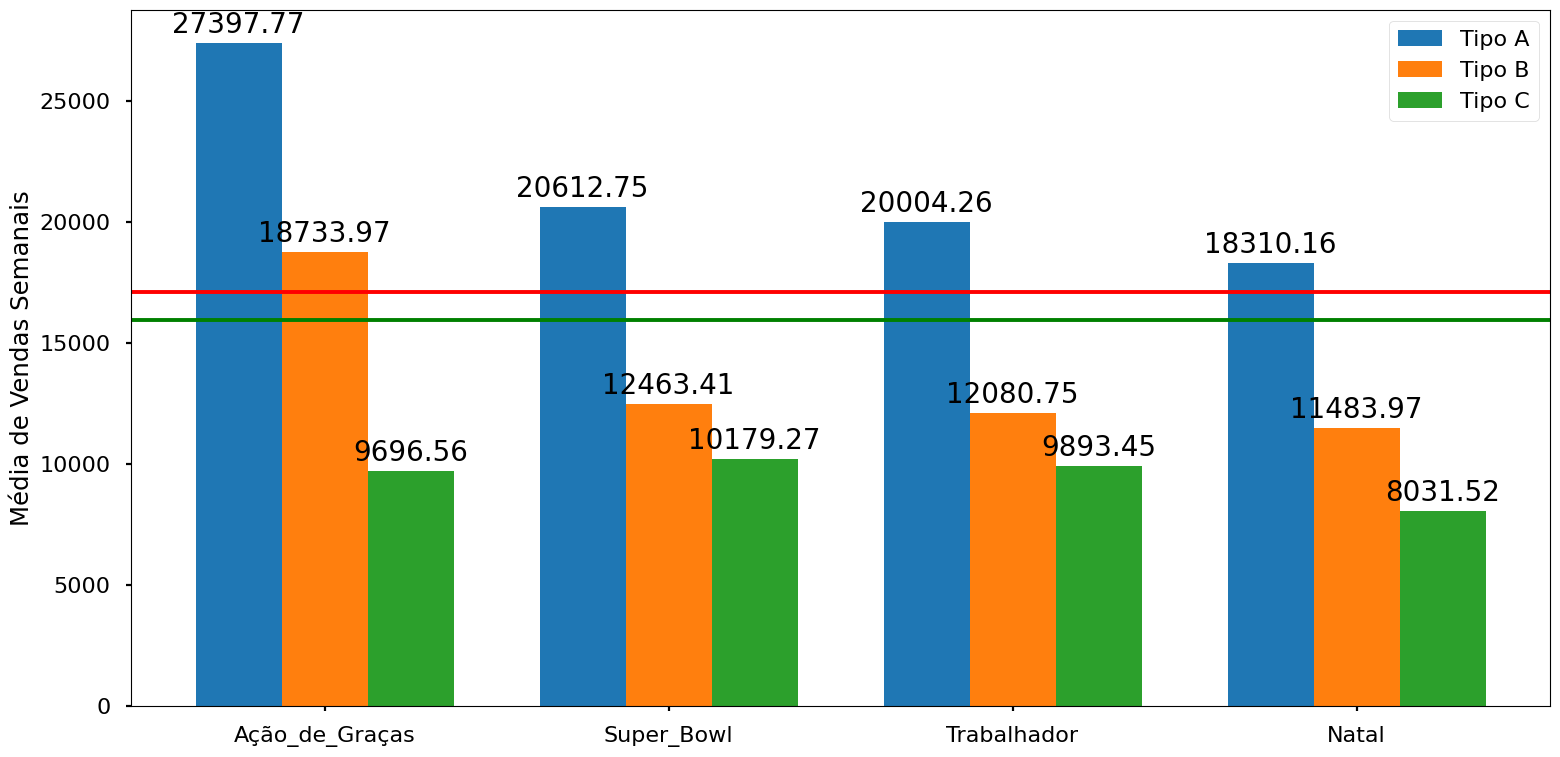

In [ ]:
## Gráfico de vendas semanais médias de acordo com feriados por tipos
plt.style.use('seaborn-poster')
labels = ['Ação_de_Graças', 'Super_Bowl', 'Trabalhador', 'Natal']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))  # localização dos rótulos
width = 0.25  # espessura das barras

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Tipo A')
rects2 = ax.bar(x , B_means, width, label='Tipo B')
rects3 = ax.bar(x + width, C_means, width, label='Tipo C')

# Adicionar texto para rótulos, título e rótulo do eixo X, etc.
ax.set_ylabel('Média de Vendas Semanais')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 pontos verticais offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # linha média feriados
plt.axhline(y=15952.82,color='green') # linha média não-feriados

fig.tight_layout()

plt.show()

In [ ]:
# É mostrado no gráfico que a maior média de vendas é na semana de Ação de Graças entre feriados.
# E, para todos feriados lojas tipo A têm maiores vendas
df.sort_values(by='Venda_Semanal',ascending=False).head(5)

# Top 5 vendas semanais todas em Ação de Graças

,Loja,Depart,Data,Venda_Semanal,Feriado,Temperatura,Preco_gasolina,Desconto1,Desconto2,Desconto3,Desconto4,Desconto5,IPC,Desemprego,Tipo,Tamanho,Super_Bowl,Trabalhador,Ação_de_Graças,Natal
90645,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
337053,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
94393,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
333594,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
131088,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


In [ ]:
## Tamanho e Tipo de loja
df_Loja.groupby('Tipo').describe()['Tamanho'].round(2) # Ver relação tamanho-tipo

,count,mean,std,min,25%,50%,75%,max
Tipo,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


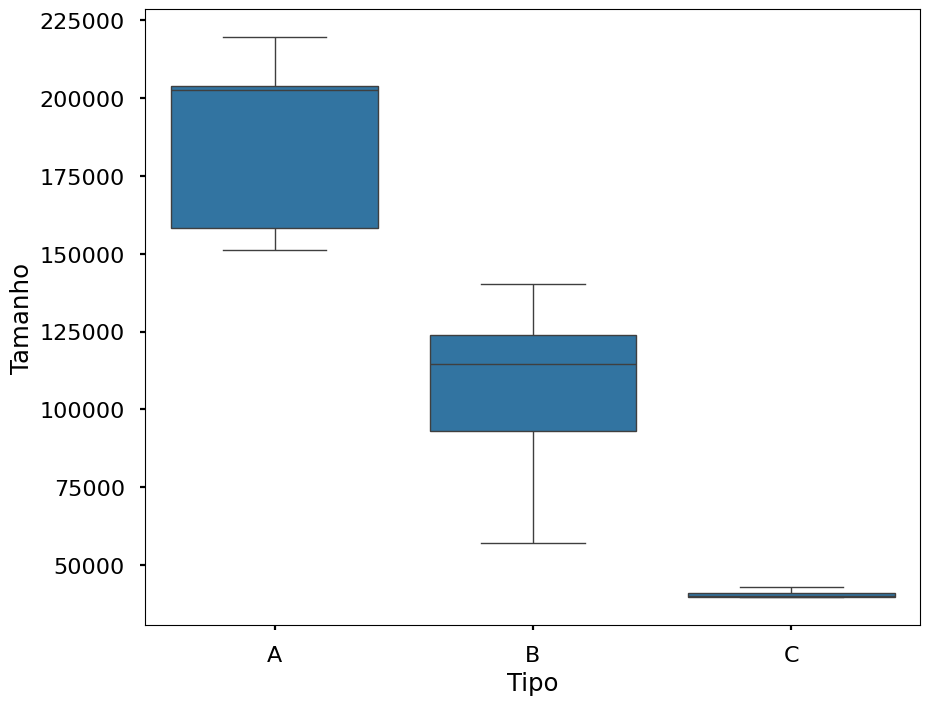

In [ ]:
plt.figure(figsize=(10,8)) # Ver relação tamanho-tipo
fig = sns.boxplot(x='Tipo', y='Tamanho', data=df, showfliers=False)

In [ ]:
# Tamanho do tipo de loja é consistente com vendas. Maior o tamanho, maiores as vendas.
# Walmart classifica lojas de acordo com seus tamanhos de acordo com o gráfico.
# Após o menor tamanho do tipo A, vem o tipo B, e assim sucessivamente.


In [ ]:
### Colunas Descontos
# Walmart criou a coluna descontos para ver o efeito nas vendas.
# Muitos missings nessas colunas. Substituo por 0, pois descontos sempre têm valores.
df.isna().sum()

,0
Loja,0
Depart,0
Data,0
Venda_Semanal,0
Feriado,0
Temperatura,0
Preco_gasolina,0
Desconto1,270031
Desconto2,309308
Desconto3,283561


In [ ]:
df = df.fillna(0) # Substitui missings por 0
df.isna().sum() # Última checagem de missings

,0
Loja,0
Depart,0
Data,0
Venda_Semanal,0
Feriado,0
Temperatura,0
Preco_gasolina,0
Desconto1,0
Desconto2,0
Desconto3,0


In [ ]:
df.describe() # ver dados estatísticos

,Loja,Depart,Venda_Semanal,Temperatura,Preco_gasolina,Desconto1,Desconto2,Desconto3,Desconto4,Desconto5,IPC,Desemprego,Tamanho
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


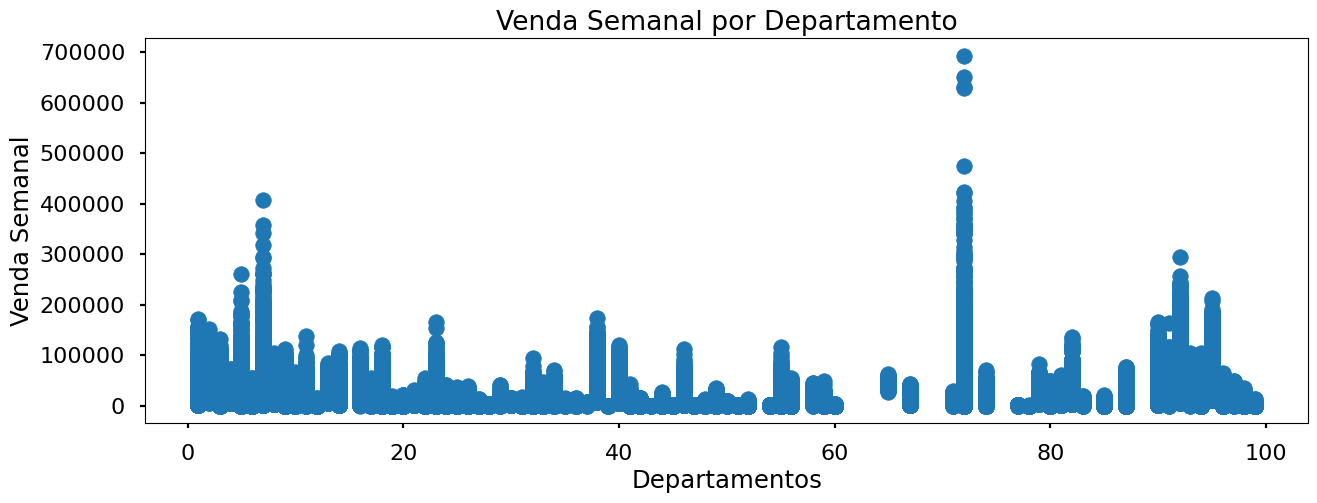

In [ ]:
######### Análise de Vendas #########
x = df['Depart']
y = df['Venda_Semanal']
plt.figure(figsize=(15,5))
plt.title('Venda Semanal por Departamento')
plt.xlabel('Departamentos')
plt.ylabel('Venda Semanal')
plt.scatter(x,y)
plt.show()

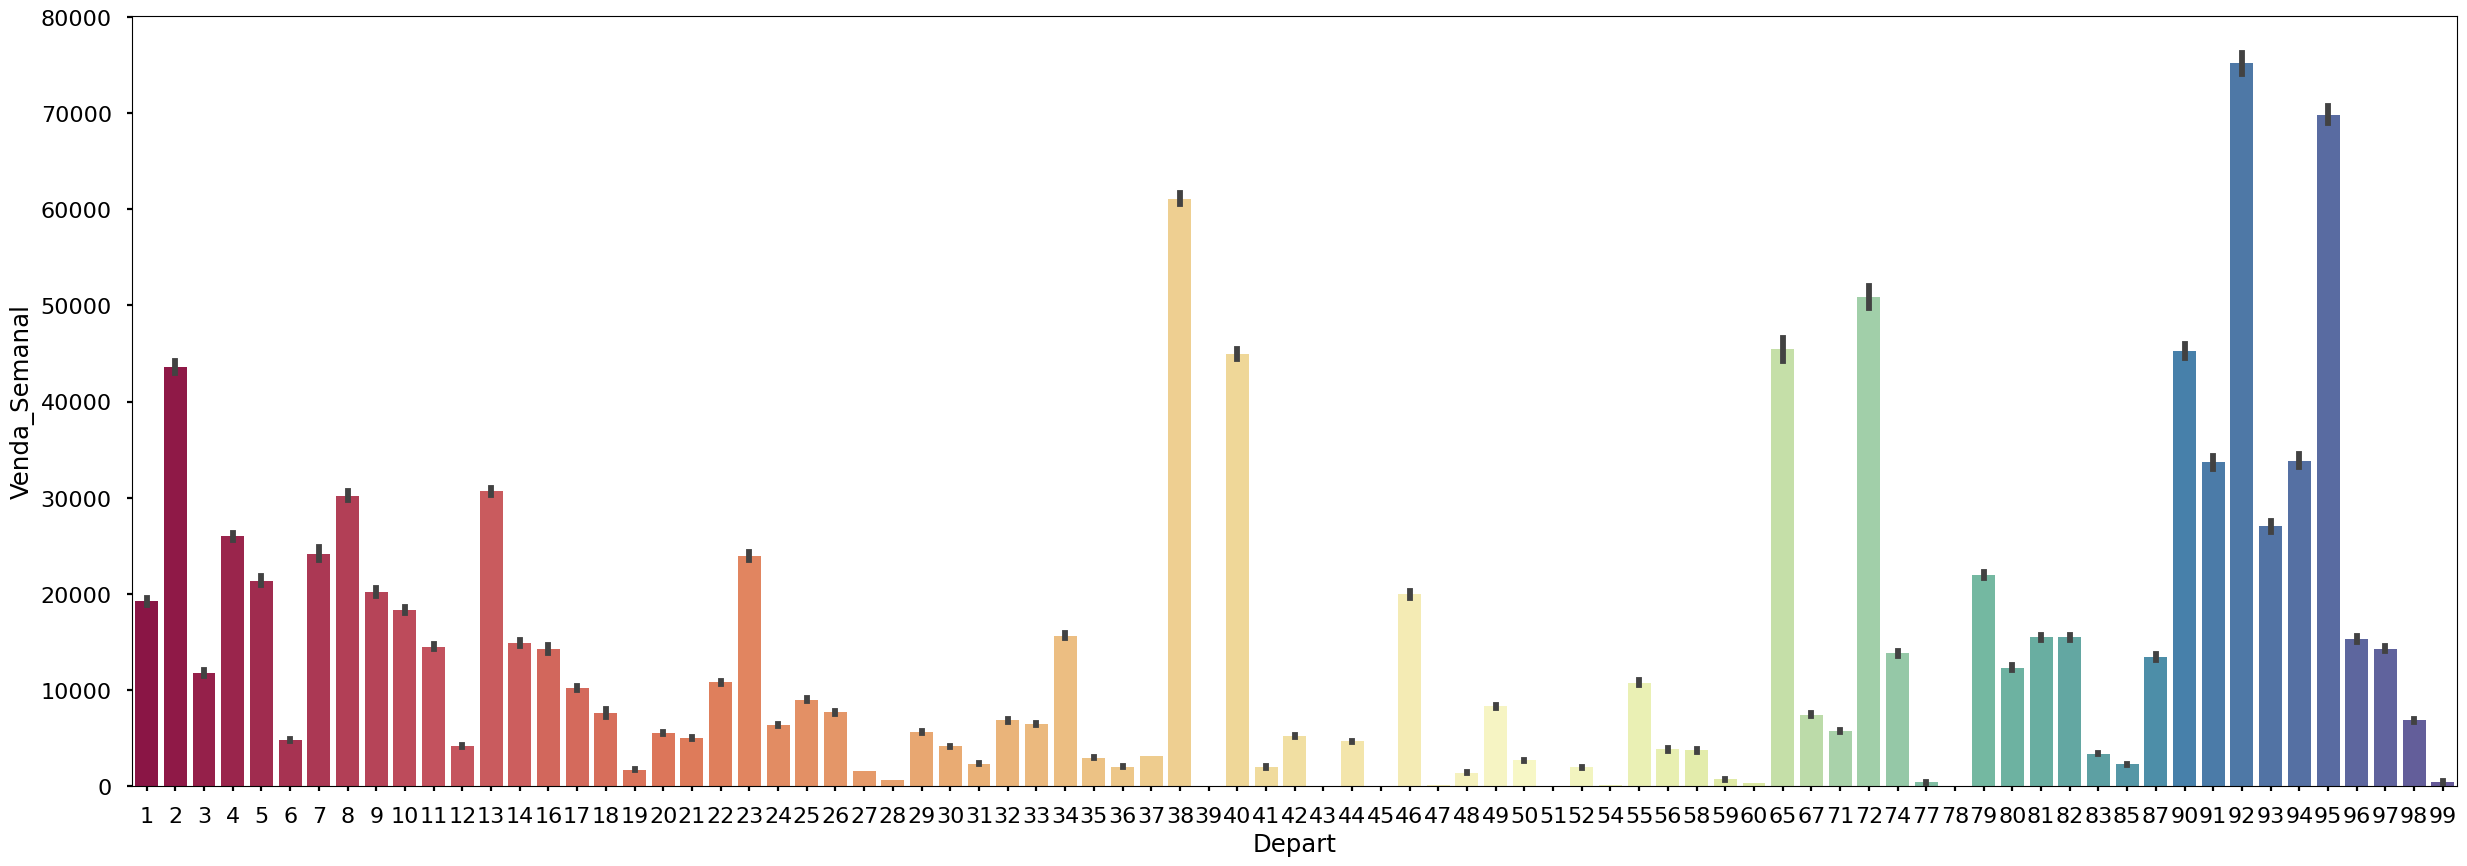

In [ ]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Depart', y='Venda_Semanal', data=df, hue='Depart', legend = False, palette="Spectral")

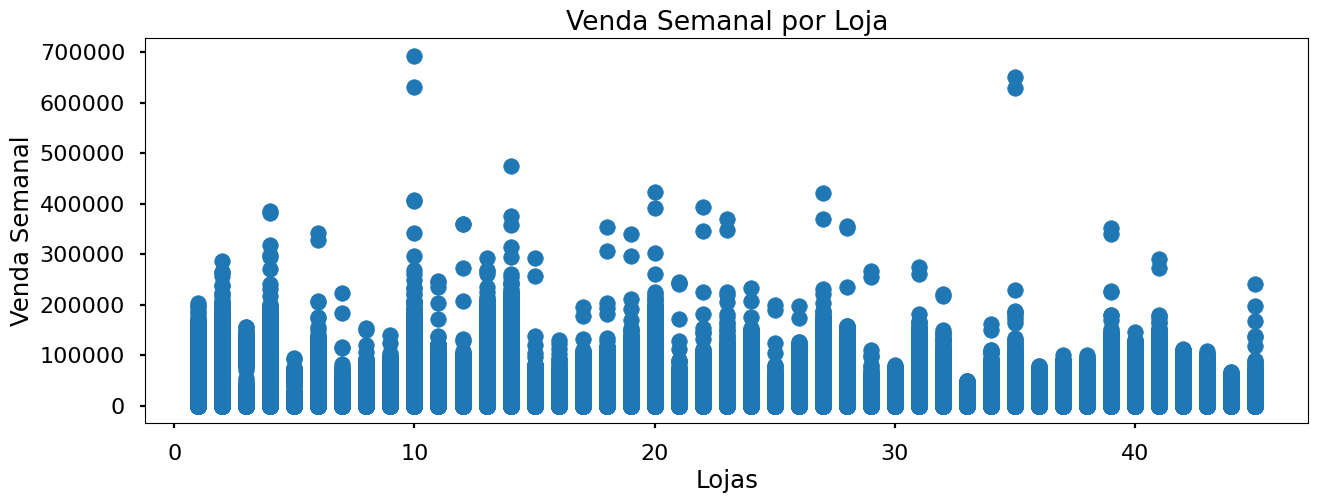

In [ ]:
#No primeiro gráfico, um departamento entre 60-80(digamos 72), tem valores maiores de vendas.
#Mas nas médias, o departamento 92 tem vendas maiores.
#Departamento 72 pode ser sazonal.
#Tem valores maiores em algumas épocas mas na média o 92 é maior.

# Agora com lojas
x = df['Loja']
y = df['Venda_Semanal']
plt.figure(figsize=(15,5))
plt.title('Venda Semanal por Loja')
plt.xlabel('Lojas')
plt.ylabel('Venda Semanal')
plt.scatter(x,y)
plt.show()

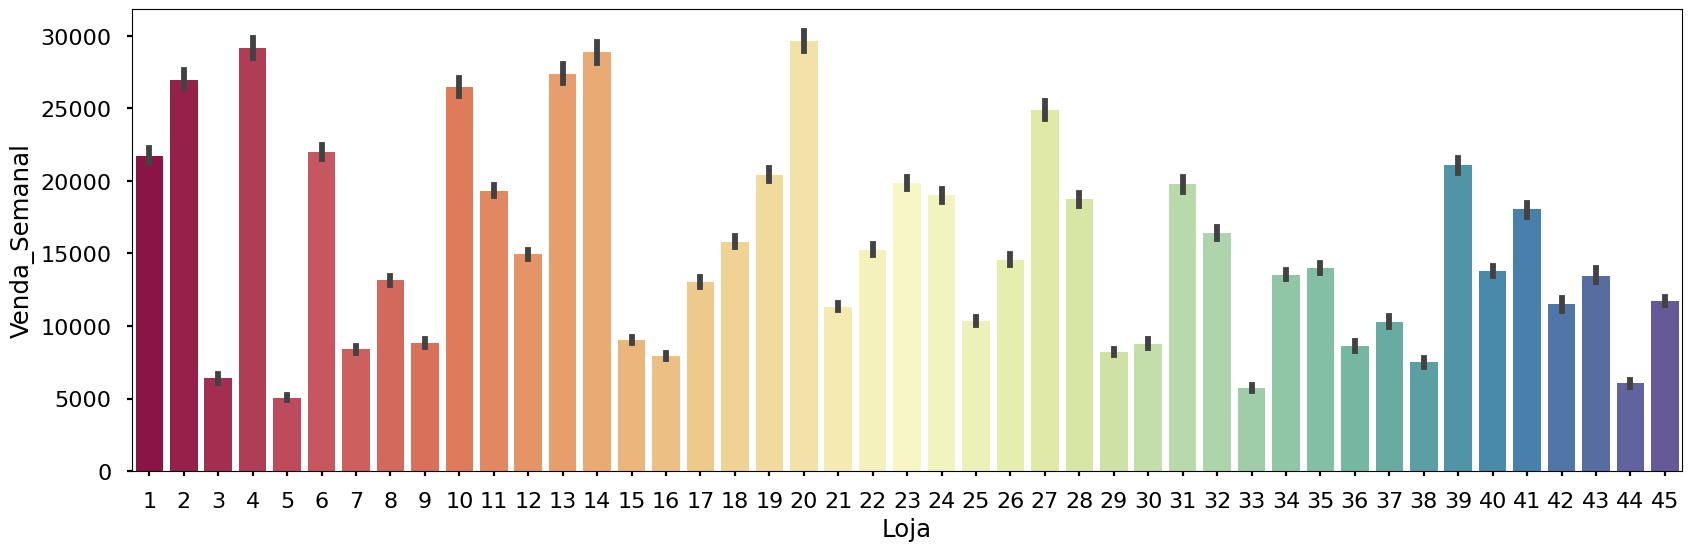

In [ ]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Loja', y='Venda_Semanal', data=df, hue='Loja', legend = False, palette='Spectral')

In [ ]:
# O mesmo ocorre com lojas. No primeiro gráfico, algumas lojas com vendas maiores.
# Mas a maior médio é a loja 20, seguindo a 4 e 14

######### Mudando Data para Datetime e Novas Colunas #########
df["Data"] = pd.to_datetime(df["Data"]) # converte para datetime
df['semana'] =df['Data'].dt.isocalendar().week # Use dt.isocalendar().week to extract week number
df['semana'] = df['semana'].astype(str) # converte semana para str
df['mês'] =df['Data'].dt.month
df['ano'] =df['Data'].dt.year

In [ ]:
df.groupby('mês')['Venda_Semanal'].mean() # Ver os melhores meses para média de vendas

,Venda_Semanal
mês,
1,14182.239153
2,16048.701191
3,15464.817698
4,15696.435193
5,15845.556200
6,16397.605478
7,15905.472425
8,16113.800069
9,15147.216063


In [ ]:
df.groupby('ano')['Venda_Semanal'].mean() # Ver os melhores anos para média de vendas

,Venda_Semanal
ano,
2010,16318.648285
2011,16007.797985
2012,15748.265005


<Axes: xlabel='mês'>

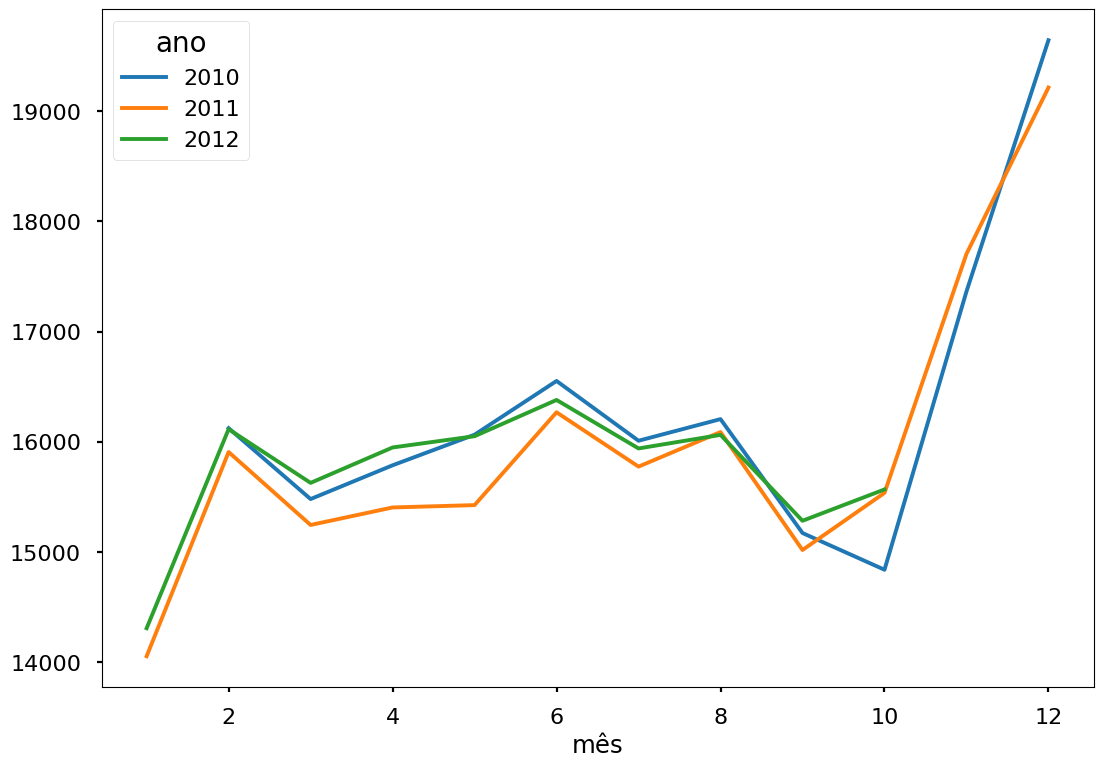

In [ ]:
vendas_mensais = pd.pivot_table(df, values = "Venda_Semanal", columns = "ano", index = "mês")
vendas_mensais.plot()

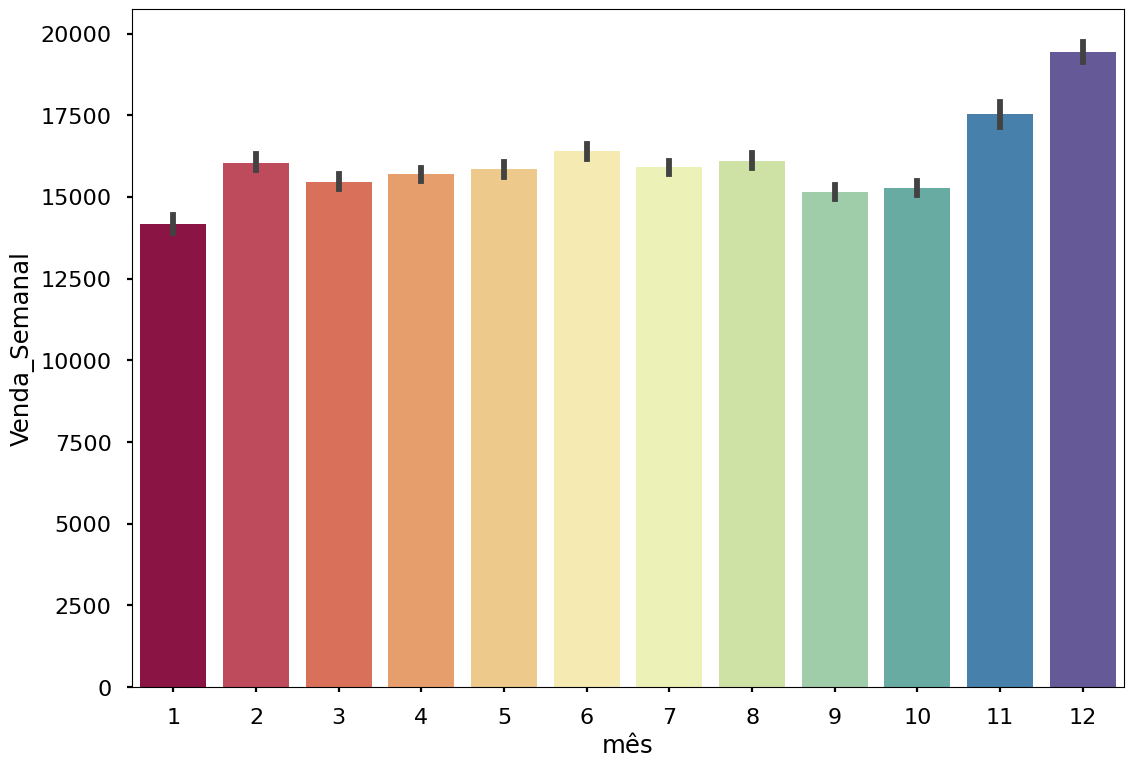

In [ ]:
# Pelo gráfico, 2011 foi abaixo de 2010 em vendas.
# Na média, 2010 parece ser maior, mas 2012 não tem informaçãoes sobre Novembro e Dezembro que são as maiores vendas.
# Mesmo 2012 sem dois meses, sua média é próxima de 2010.
# Provavelmente, ficaria em primeiro se adicionarmos os resultados perdidos de 2012.

fig = sns.barplot(x='mês', y='Venda_Semanal', hue='mês', data=df, legend = False, palette='Spectral')

In [ ]:
# No gráfico acima, as melhores vendas são em Novembro e Dezembro, como esperado.
# Os maiores valores pertencem a Ação de Graças, mas na média, Dezembro tem os maiores valores.

df.groupby('semana')['Venda_Semanal'].mean().sort_values(ascending=False).head()

,Venda_Semanal
semana,
51,26454.164116
47,22269.601768
50,20478.421134
49,18731.794840
22,16856.650245


<Axes: xlabel='semana'>

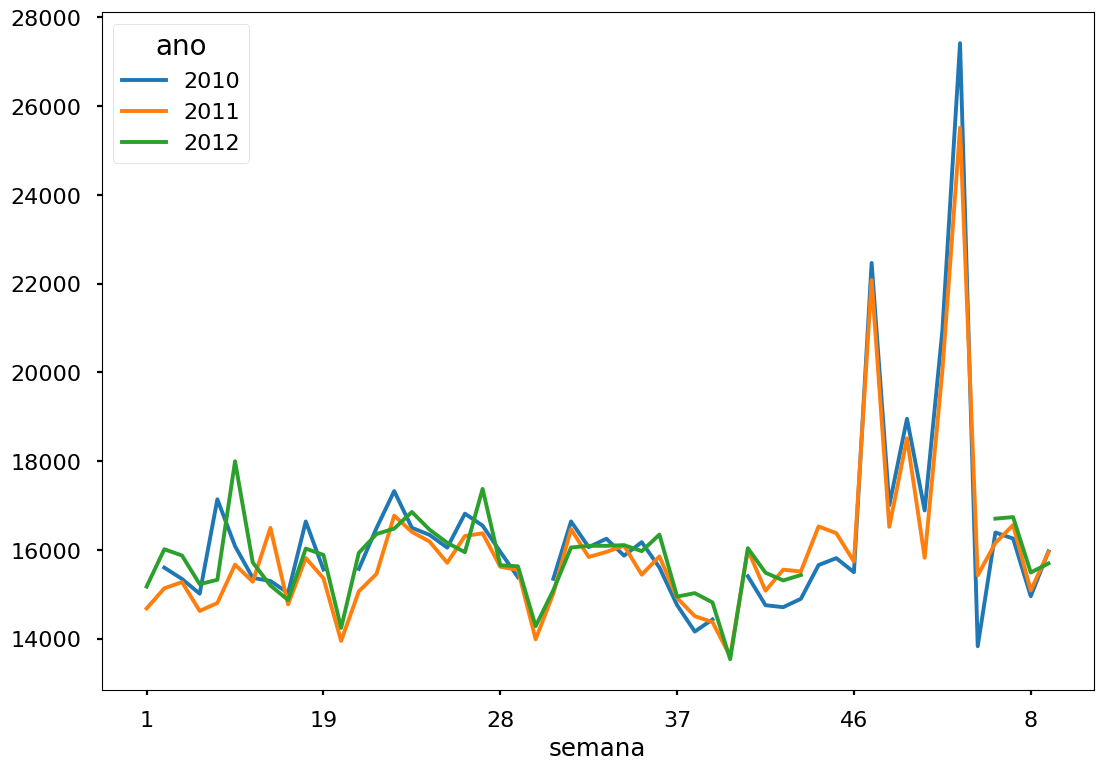

In [ ]:
# Top 5 médias de venda por semana pertencem às 1-2 semanas antes do Natal, Ação de Graças, Black Friday e fim de Maio, quando escolas fecham.

Vendas_Semanais = pd.pivot_table(df, values = "Venda_Semanal", columns = "ano", index = "semana")
Vendas_Semanais.plot()

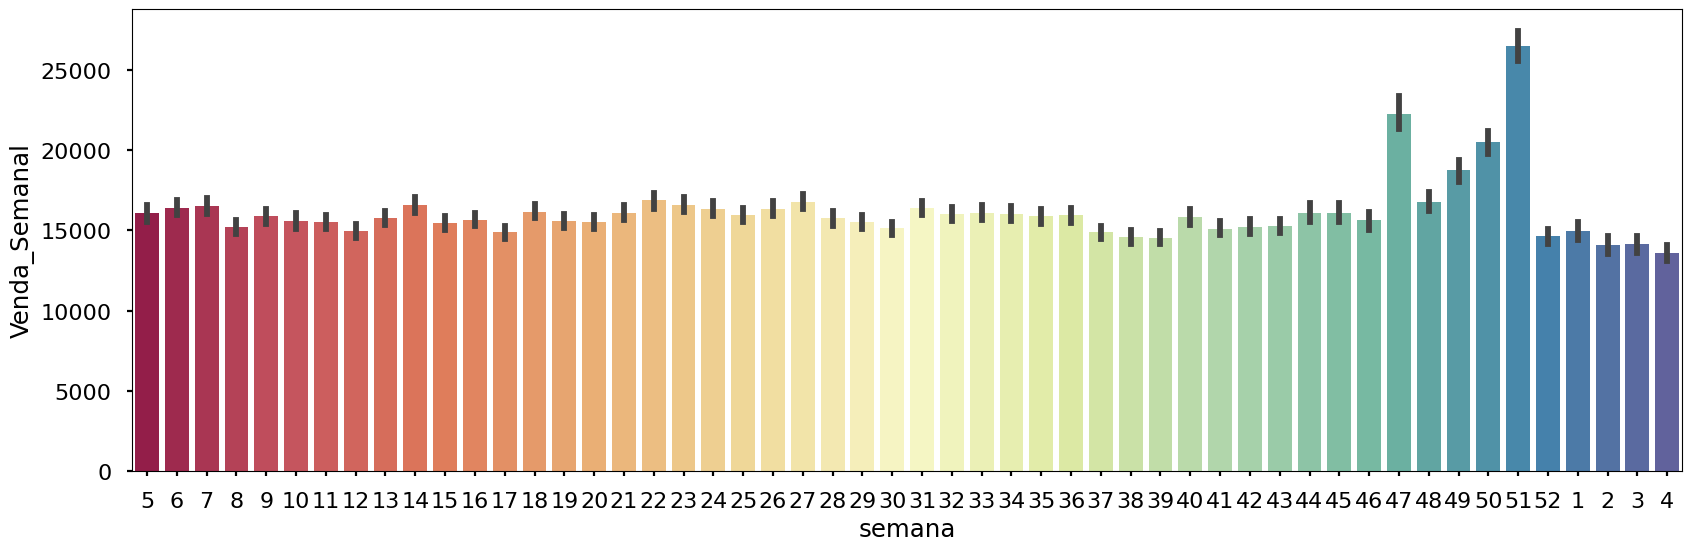

In [ ]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='semana', y='Venda_Semanal', hue='semana', data=df, legend = False, palette='Spectral')

<Axes: xlabel='Preco_gasolina'>

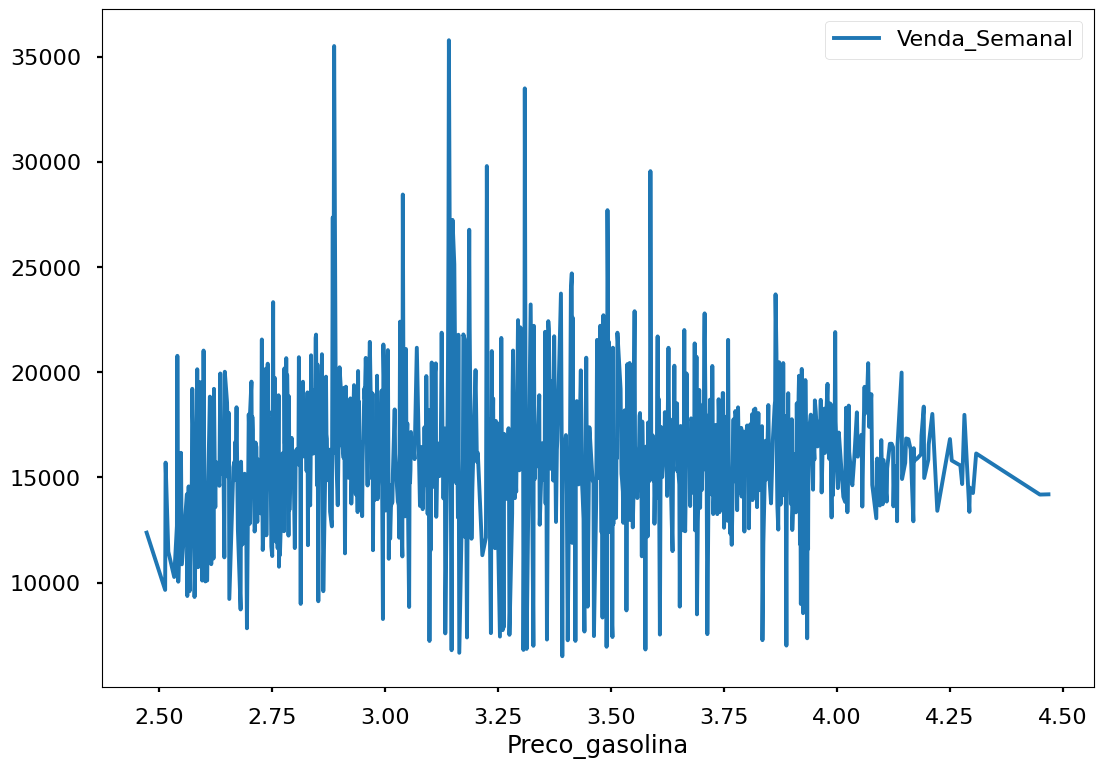

In [ ]:
# Pelos gráficos, as semanas 51 e 47 têm médias maiores com efeitos do Natal, Ação de Graças e Black Friday.



######### Efeitos do Preço da Gasolina, IPC, Desemprego e Temperatura #########
# Preço Gasolina
preco_gasolina = pd.pivot_table(df, values = "Venda_Semanal", index= "Preco_gasolina")
preco_gasolina.plot()

<Axes: xlabel='Temperatura'>

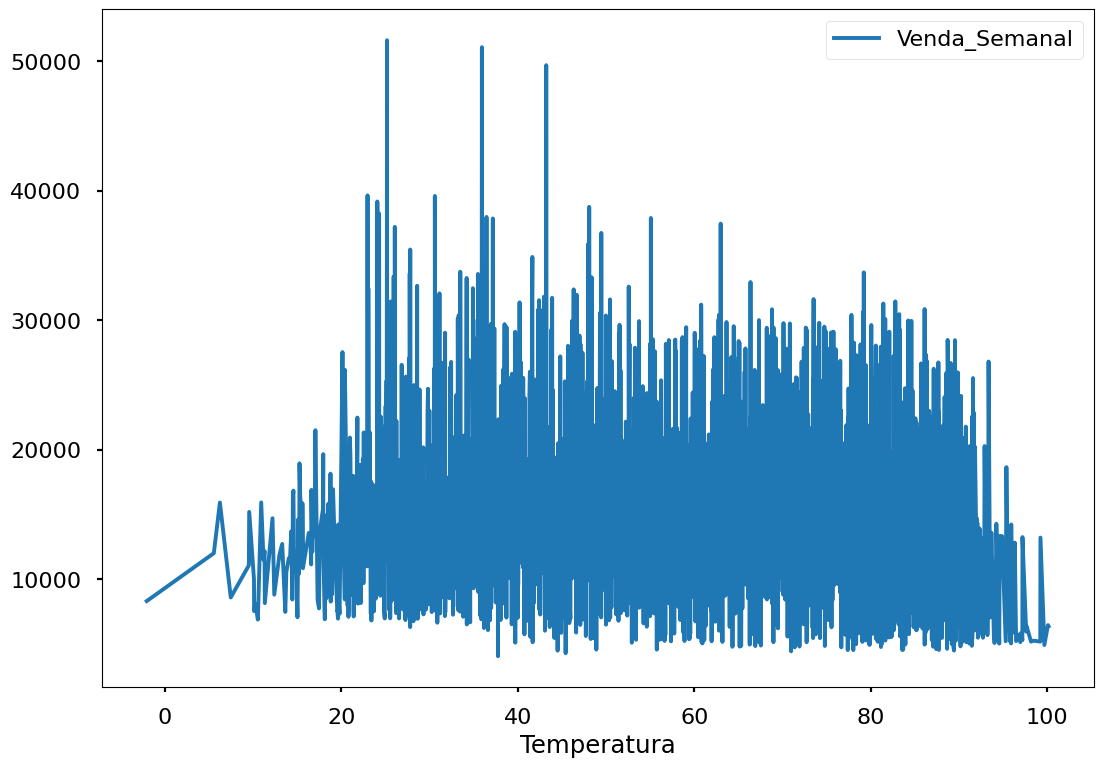

In [ ]:
# Temperatura
temp = pd.pivot_table(df, values = "Venda_Semanal", index= "Temperatura")
temp.plot()

<Axes: xlabel='IPC'>

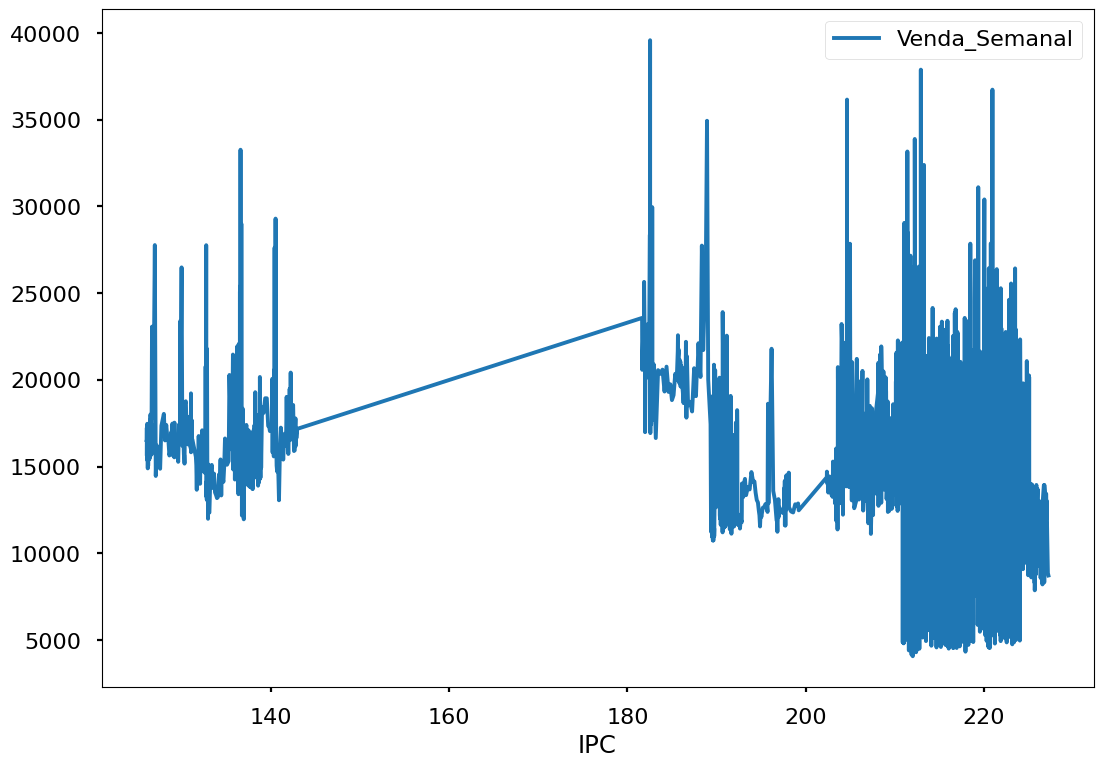

In [ ]:
# IPC
IPC = pd.pivot_table(df, values = "Venda_Semanal", index= "IPC")
IPC.plot()

<Axes: xlabel='Desemprego'>

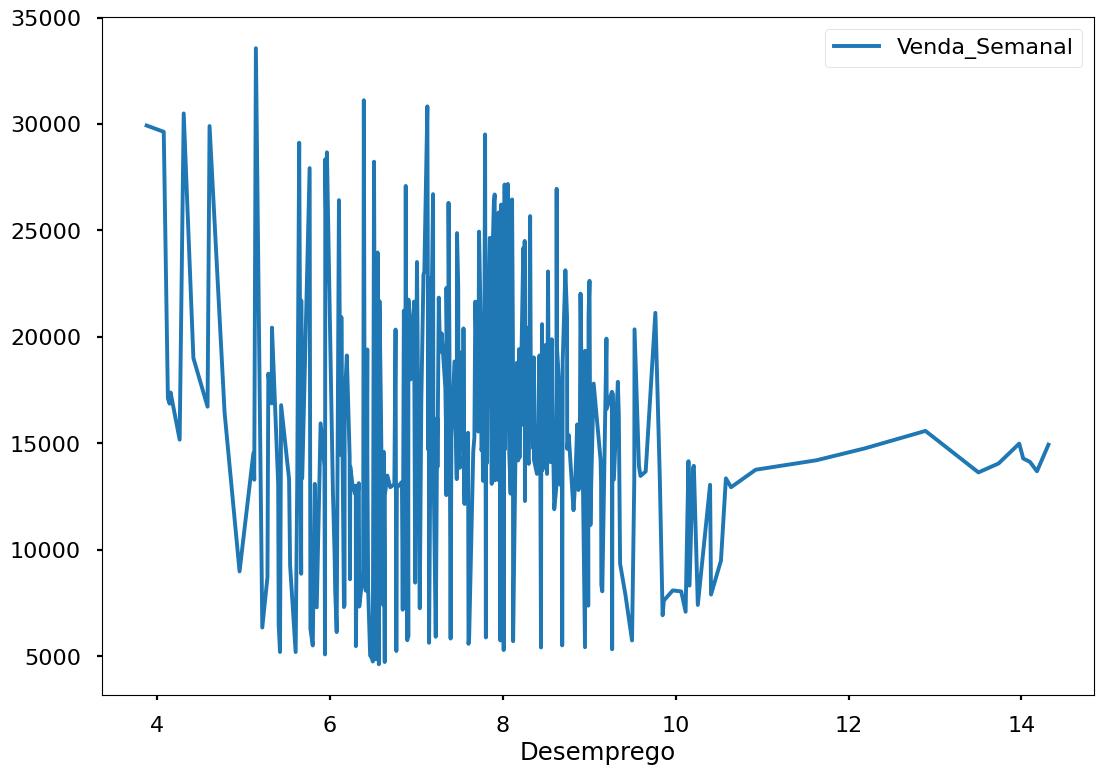

In [ ]:
# Desemprego
desemprego = pd.pivot_table(df, values = "Venda_Semanal", index= "Desemprego")
desemprego.plot()

In [ ]:
# Pelos gráficos, não há padrão significativo para IPC, temperatura, desemprego, preço gasolina vs vendas semanais.
# Não há dados para IPC entre 140-180.

df.to_csv('clean_data.csv') # Cria novo data frame para o csv
# Será necessário um CSV limpo para realizar uma análise de Regressão de Floresta Aleatória (Random Forest Regressor)

In [ ]:
####### Rondom Forest Regressor #######
# A métrica para o projeto será pesada por weighted mean absolute error (WMAE)
# Nesta métrica, o erro em semanas de feriado tem 5 vezes mais peso que semanas normais.
# Portanto, deve-se predizer as vendas em feriados precisamente.

pd.options.display.max_columns=100 # visualização de colunas

In [ ]:
df = pd.read_csv('clean_data.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df['Data'] = pd.to_datetime(df['Data']) # Mudando datetime para dividir se precisar
df.head()

,Loja,Depart,Data,Venda_Semanal,Feriado,Temperatura,Preco_gasolina,Desconto1,Desconto2,Desconto3,Desconto4,Desconto5,IPC,Desemprego,Tipo,Tamanho,Super_Bowl,Trabalhador,Ação_de_Graças,Natal,semana,mês,ano
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010


In [ ]:
# Codificando Dados
# Para processar os dados, mudarei os feriados para boolean (0-1)
# E substituir as lojas A, B, C por 1, 2, 3

df_codificado = df.copy() # Mantém o dataframe original tomando uma cópia dele
grupo_tipo = {'A':1, 'B': 2, 'C': 3}  # muda A,B,C para 1-2-3
df_codificado['Tipo'] = df_codificado['Tipo'].replace(grupo_tipo)
df_codificado['Super_Bowl'] = df_codificado['Super_Bowl'].astype(bool).astype(int) # Muda T,F para 0-1
df_codificado['Ação_de_Graças'] = df_codificado['Ação_de_Graças'].astype(bool).astype(int) # Muda T,F para 0-1
df_codificado['Trabalhador'] = df_codificado['Trabalhador'].astype(bool).astype(int) # Muda T,F para 0-1
df_codificado['Natal'] = df_codificado['Natal'].astype(bool).astype(int) # Muda T,F para 0-1
df_codificado['Feriado'] = df_codificado['Feriado'].astype(bool).astype(int) # Muda T,F para 0-1
df_novo = df_codificado.copy() # Toma cópia do codificado df para manter original

In [ ]:
## Observação das interações entre características ##
# Primeiro, retiro colunas de feriados divididas dos meus dados e tento sem.
# Para manter o codificado seguro, designo meu dataframa para o novo e o utilizo.

drop_col = ['Super_Bowl','Trabalhador','Ação_de_Graças','Natal']
df_novo.drop(drop_col, axis=1, inplace=True) # Retiro colunas

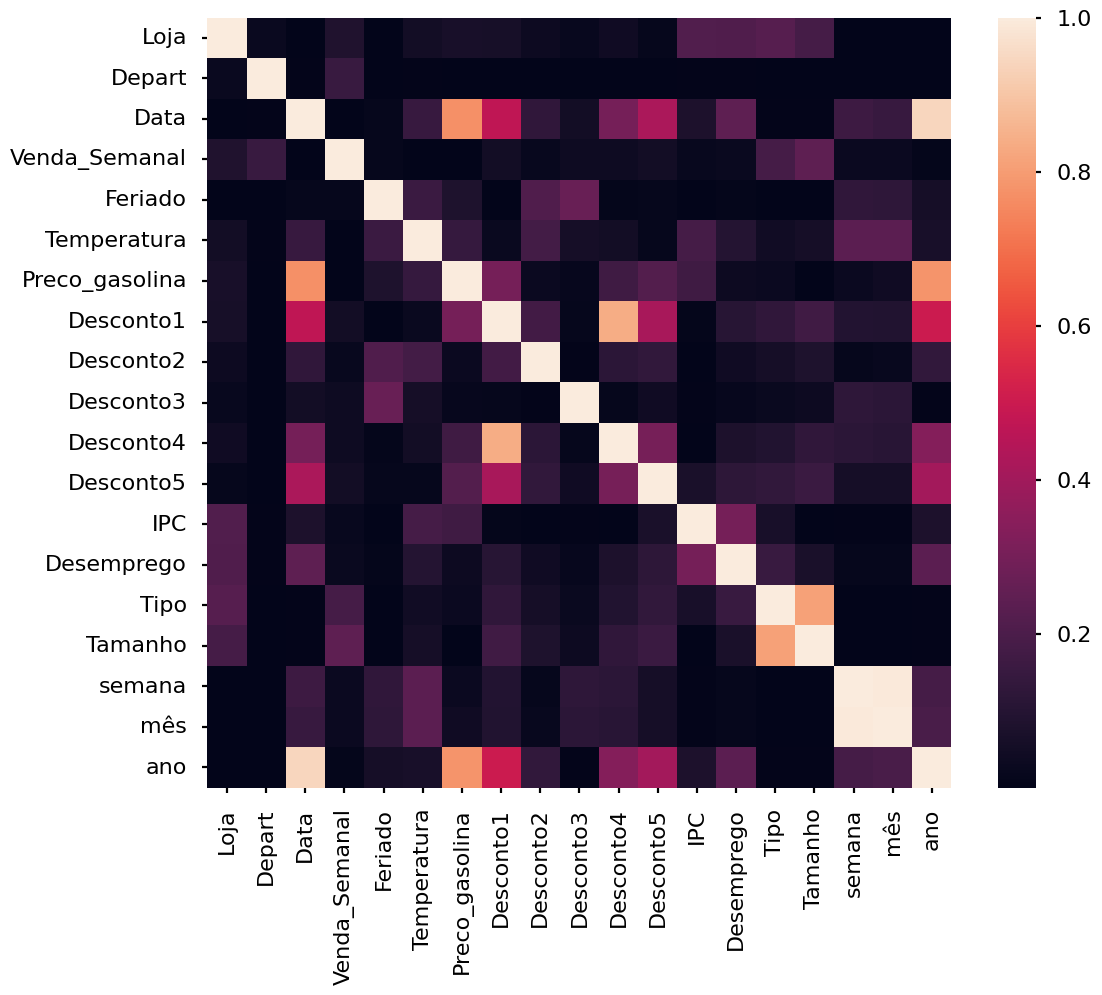

In [ ]:
plt.figure(figsize = (12,10))
sns.heatmap(df_novo.corr().abs())    # Ver correlações
plt.show()

In [ ]:
# Temperatura, desemprego, IPC não têm efeito sobre vendas semanais, então retiro.
# Desconto 4 e 5 muito correlatos com 1. Retiro para evitar multicolinearidade.

drop_col = ['Temperatura','Desconto4','Desconto5','IPC','Desemprego']
df_novo.drop(drop_col, axis=1, inplace=True) # Retira colunas

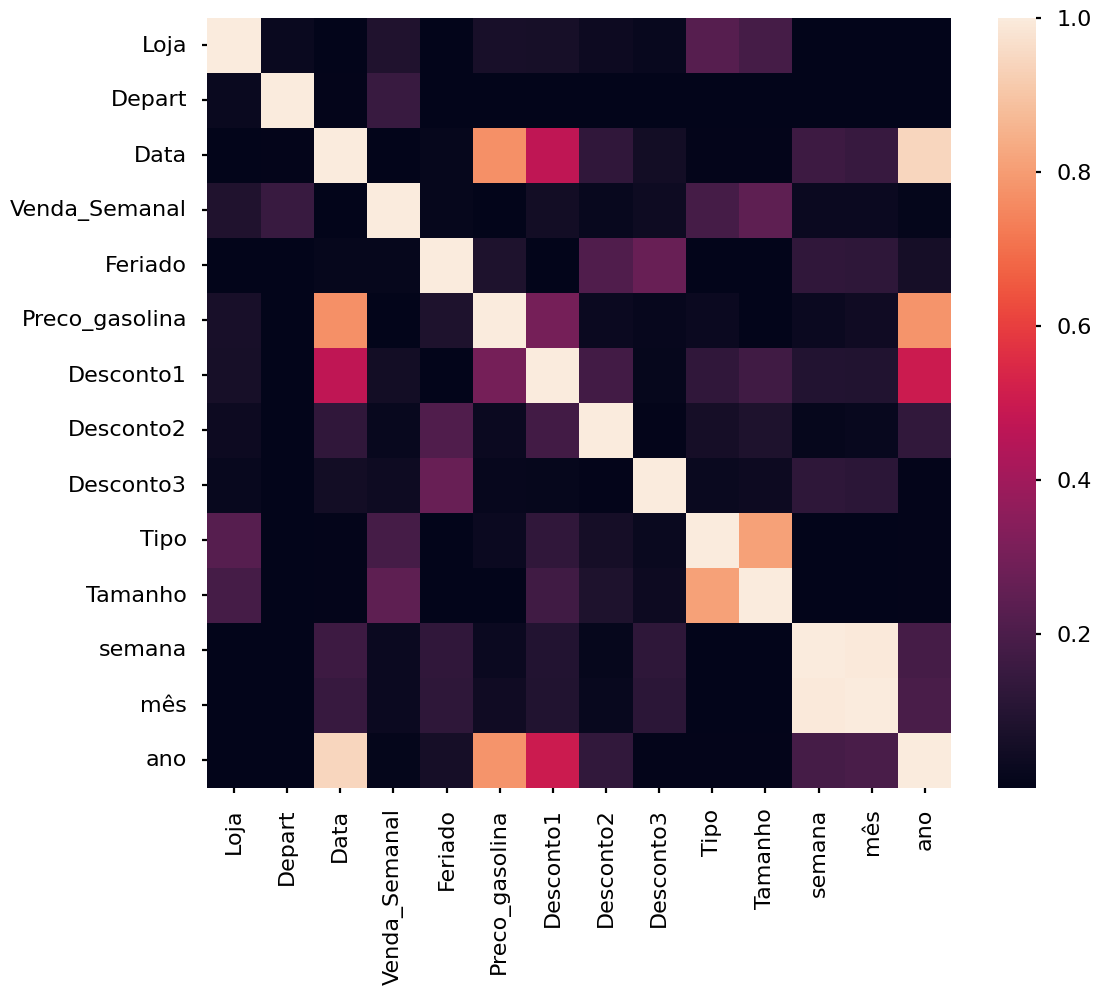

In [ ]:
plt.figure(figsize = (12,10))
sns.heatmap(df_novo.corr().abs())    # Nova correlação sem as colunas anteriores
plt.show()

In [ ]:
# Tamanho e tipo são altamente correlatos com vendas semanais.
# Departamento e loja são correlatos com vendas.

df_novo = df_novo.sort_values(by='Data', ascending=True) # Organiza de acordo com data

In [ ]:
## Criando divisão Treino-Teste ##
# Coluna data tem valores contínuos, para manter as características de data contínua.
# Não farei divisão aleatória. Divido os dados manualmente por 70%.

treino_dados = df_novo[:int(0.7*(len(df_novo)))] # Pegando a parte treino
teste_dados = df_novo[int(0.7*(len(df_novo))):] # Pegando a parte teste

alvo = "Venda_Semanal"
cols_usadas = [c for c in df_novo.columns.to_list() if c not in [alvo]] # todas colunas exceto venda_semanal

X_treino = treino_dados[cols_usadas]
X_teste = teste_dados[cols_usadas]
y_treino = treino_dados[alvo]
y_teste = teste_dados[alvo]

X = df_novo[cols_usadas] # manter valores X de treino e teste juntos

In [ ]:
# Temos informação suficiente em datas como semana do ano.
# Portanto, retiro coluna Data
X_treino = X_treino.drop(['Data'], axis=1) # Retiro data de treino
X_teste = X_teste.drop(['Data'], axis=1) # Retiro data de teste

In [ ]:
## Função de definição métrica ##
# Nossa métrica não é calculada como padrão por modelos prontos.
# É erro pesado portanto, uso a função abaixo para calculá-la.

def wmae_test(teste, pred): # WMAE para teste
    pesos = X_teste['Feriado'].apply(lambda feriado:5 if feriado else 1)
    erro = np.sum(pesos * np.abs(teste - pred), axis=0) / np.sum(pesos)
    return erro

In [ ]:
## Regressão de Floresta Aleatória ##
# Escolhi os parâmetros manualmente porque com gridsearch iria levar muito tempo.

rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()


# Faz pipe tp usar scaler e regressor juntos
pipe = make_pipeline(scaler,rf)

pipe.fit(X_treino, y_treino)

# Predições no set de treino
y_pred = pipe.predict(X_treino)

# Predições no set de teste
y_pred_teste = pipe.predict(X_teste)

In [ ]:
wmae_test(y_teste, y_pred_teste)

5850.444413125214

In [ ]:
# Primeira tentativa, erro pesado por volta de 5850.

## Ver a importância das Características
X = X.drop(['Data'], axis=1) # Retira coluna Data de X

Ranque de Características:
1. característica 1 (0.732822)
2. característica 8 (0.110390)
3. característica 0 (0.054027)
4. característica 7 (0.038210)
5. característica 9 (0.021277)
6. característica 3 (0.018402)
7. característica 10 (0.009446)
8. característica 6 (0.005523)
9. característica 4 (0.003413)
10. característica 5 (0.002776)
11. característica 2 (0.002246)
12. característica 11 (0.001467)


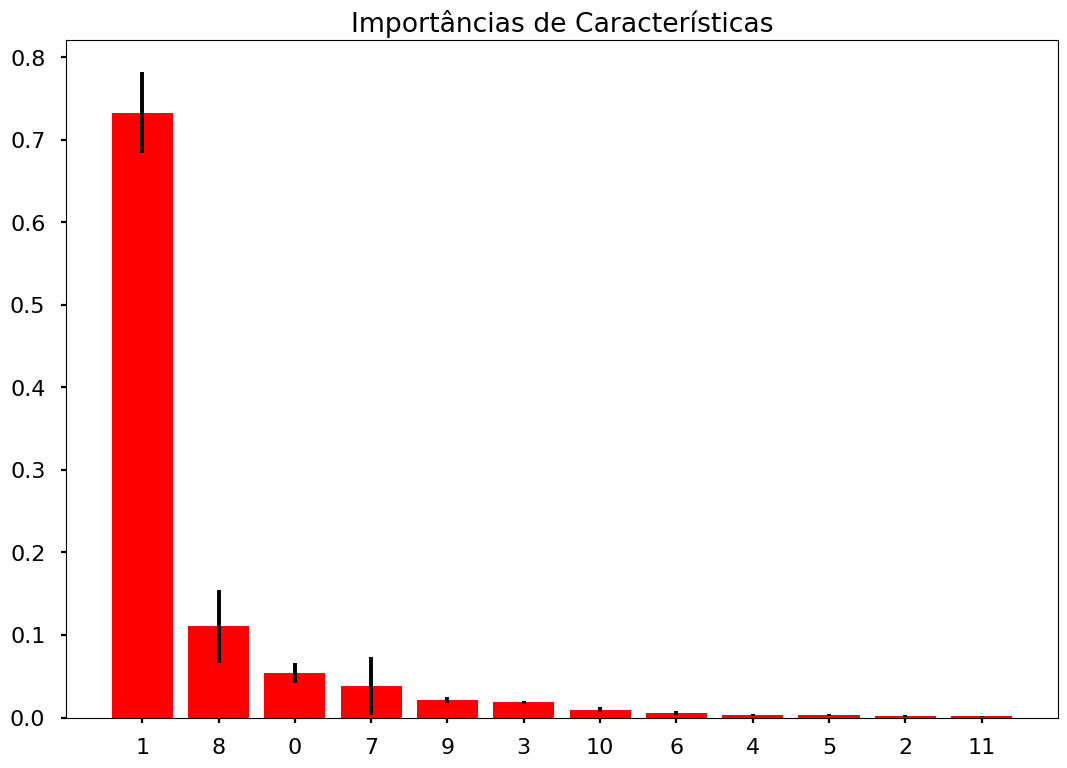

In [ ]:
importancias = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importancias)[::-1]

# Imprime o ranque de características
print("Ranque de Características:")

for f in range(X.shape[1]):
    print("%d. característica %d (%f)" % (f + 1, indices[f], importancias[indices[f]]))

# Gráfico de importância de características da floresta
plt.figure()
plt.title("Importâncias de Características")
plt.bar(range(X.shape[1]), importancias[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
# Após gráfico, retiro de 3-4 características menos importantes e tento modelo.
# Melhor resultado quando retiro coluna mês que é altamente correlata com semana.

X1_treino = X_treino.drop(['mês'], axis=1) # Retirando mês
X1_teste = X_teste.drop(['mês'], axis=1)

In [ ]:
## Modelo sem Mês
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X1_treino, y_treino)

# Predições no set de treino
y_pred = pipe.predict(X1_treino)

# Predições no set de teste
y_pred_teste = pipe.predict(X1_teste)

In [ ]:
wmae_test(y_teste, y_pred_teste)

5494.419090545123

In [ ]:
# Resultado melhor que anterior

## Modelo todos os Dados
# Garantir que o modelo vai aprender pelas colunas retiradas.
# Aplico o modelo para todos os dados codificados novamente.

# Dividindo treino-teste para todo dataset
treino_dados_cod = df_codificado[:int(0.7*(len(df_codificado)))]
teste_dados_cod = df_codificado[int(0.7*(len(df_codificado))):]

alvo = "Venda_Semanal"
cols_usadas1 = [c for c in df_codificado.columns.to_list() if c not in [alvo]] # Todas colunas exceto preço

X_treino_cod = treino_dados_cod[cols_usadas1]
X_teste_cod = teste_dados_cod[cols_usadas1]
y_treino_cod = treino_dados_cod[alvo]
y_teste_cod = teste_dados_cod[alvo]

In [ ]:
X_cod = df_codificado[cols_usadas1] # Para juntas novamente treino e teste
X_cod = X_cod.drop(['Data'], axis=1) # Retiro coluna data para todo X
X_treino_cod = X_treino_cod.drop(['Data'], axis=1) # Retiro data de treino e teste
X_teste_cod= X_teste_cod.drop(['Data'], axis=1)

In [ ]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_treino_cod, y_treino_cod)

# Predições no set de treino
y_pred_cod = pipe.predict(X_treino_cod)

# Predições no set de teste
y_pred_teste_cod = pipe.predict(X_teste_cod)


In [ ]:
wmae_test(y_teste_cod, y_pred_teste_cod)

2450.1012493925496

Ranque de Características:
1. característica 1 (0.743136)
2. característica 13 (0.075801)
3. característica 12 (0.043810)
4. característica 0 (0.031172)
5. característica 10 (0.028007)
6. característica 11 (0.017039)
7. característica 18 (0.012315)
8. característica 3 (0.011079)
9. característica 4 (0.009879)
10. característica 19 (0.005534)
11. característica 7 (0.004481)
12. característica 9 (0.003979)
13. característica 5 (0.003461)
14. característica 8 (0.003315)
15. característica 6 (0.002381)
16. característica 16 (0.001363)
17. característica 20 (0.001200)
18. característica 2 (0.000879)
19. característica 17 (0.000597)
20. característica 14 (0.000290)
21. característica 15 (0.000283)


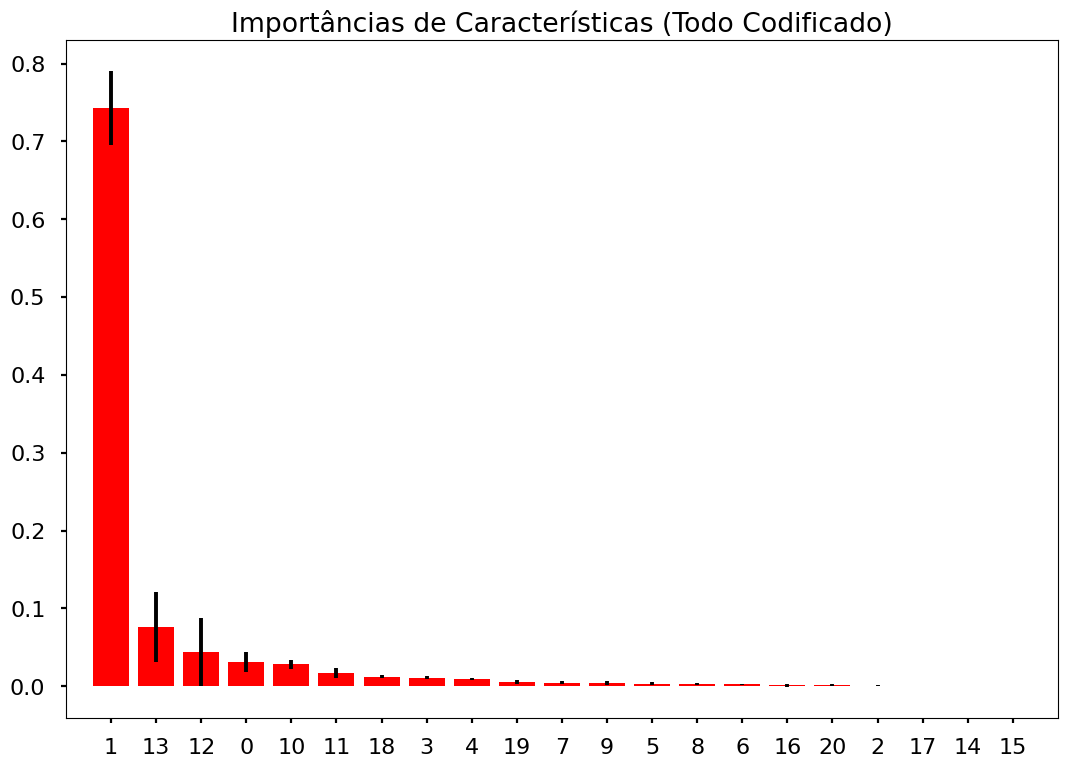

In [ ]:
# Resultados melhores com todos dados, o modelo aprende com as colunas retiradas

###### Importância de Características para todo DataSet Codificado ######
importancias = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importancias)[::-1]

# Imprime o ranque de características
print("Ranque de Características:")

for f in range(X_cod.shape[1]):
    print("%d. característica %d (%f)" % (f + 1, indices[f], importancias[indices[f]]))

# Gráfico de importância de características da floresta
plt.figure()
plt.title("Importâncias de Características (Todo Codificado)")
plt.bar(range(X_cod.shape[1]), importancias[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_cod.shape[1]), indices)
plt.xlim([-1, X_cod.shape[1]])
plt.show()

In [ ]:
# Pelo modelo, retiro algumas colunas e rodo o modelo novamente

df_codificado_novo = df_codificado.copy() # Tomo cópia do dado codificado para manter intacto
df_codificado_novo.drop(drop_col, axis=1, inplace=True)

In [ ]:
###### Modelo de Acordo com Importância de Características ######
# Divisão treino-teste
treino_dados_cod_novo = df_codificado_novo[:int(0.7*(len(df_codificado_novo)))]
teste_dados_cod_novo = df_codificado_novo[int(0.7*(len(df_codificado_novo))):]

alvo = "Venda_Semanal"
cols_usadas2 = [c for c in df_codificado_novo.columns.to_list() if c not in [alvo]] # Todas colunas exceto preço

X_treino_cod1 = treino_dados_cod_novo[cols_usadas2]
X_teste_cod1 = teste_dados_cod_novo[cols_usadas2]
y_treino_cod1 = treino_dados_cod_novo[alvo]
Y_teste_cod1 = teste_dados_cod_novo[alvo]

# retira data de treino-teste
X_treino_cod1 = X_treino_cod1.drop(['Data'], axis=1)
X_teste_cod1= X_teste_cod1.drop(['Data'], axis=1)

In [ ]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=40,
                           max_features = 'log2',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_treino_cod1, y_treino_cod1)

# Predições no set de treino
y_pred_cod = pipe.predict(X_treino_cod1)

# Predições no set de teste
y_pred_teste_cod = pipe.predict(X_teste_cod1)

In [ ]:
pipe.score(X_teste_cod1,Y_teste_cod1)

0.7397036882771106

In [ ]:
wmae_test(Y_teste_cod1, y_pred_teste_cod)

1801.5211888667177

In [ ]:
# Resultados melhores com a seleção de característica do dataset codificado inteiro


###### Modelo com Retirada da Coluna Mês ######
# Mesmo dataset anterior, mesmo modelo sem coluna mês

df_codificado_novo1 = df_codificado.copy()
df_codificado_novo1.drop(drop_col, axis=1, inplace=True)
df_codificado_novo1 = df_codificado_novo1.drop(['Data'], axis=1)
df_codificado_novo1 = df_codificado_novo1.drop(['mês'], axis=1)

In [ ]:
# Divisão Treino-teste
treino_dados_cod_novo1 = df_codificado_novo1[:int(0.7*(len(df_codificado_novo1)))]
teste_dados_cod_novo1 = df_codificado_novo1[int(0.7*(len(df_codificado_novo1))):]

alvo = "Venda_Semanal"
cols_usadas3 = [c for c in df_codificado_novo1.columns.to_list() if c not in [alvo]] # Todas colunas exceto preço

X_treino_cod2 = treino_dados_cod_novo1[cols_usadas3]
X_teste_cod2 = teste_dados_cod_novo1[cols_usadas3]
y_treino_cod2 = treino_dados_cod_novo1[alvo]
y_teste_cod2 = teste_dados_cod_novo1[alvo]

In [ ]:
# modelagem
pipe = make_pipeline(scaler,rf)

pipe.fit(X_treino_cod2, y_treino_cod2)

# Predições no set de treino
y_pred_cod = pipe.predict(X_treino_cod2)

# Predições no set de teste
y_pred_teste_cod = pipe.predict(X_teste_cod2)

In [ ]:
pipe.score(X_teste_cod2,y_teste_cod2)

0.7040151411780626

In [ ]:
wmae_test(y_teste_cod2, y_pred_teste_cod)

2093.074731200826

In [ ]:
# Resultados não foram melhores

df_resultados = pd.DataFrame(columns=["Modelo", "Info",'WMAE']) # df resultado para mostrar resultados juntos

# Coloca resultados na df
nova_linha = pd.DataFrame({
     "Modelo": ['Random Forest Regressor'],
      "Info": ['Sem coluna feriado dividida'],
       "WMAE" : [5850]})
df_resultados = pd.concat([df_resultados, nova_linha], ignore_index=True)

nova_linha = pd.DataFrame({
     "Modelo": ['Random Forest Regressor'],
      "Info": ['Sem coluna mês'],
       "WMAE" : [5494]})
df_resultados = pd.concat([df_resultados, nova_linha], ignore_index=True)

nova_linha = pd.DataFrame({
     "Modelo": ['Random Forest Regressor'],
      "Info": ['Dados completos'],
       "WMAE" : [2450]})
df_resultados = pd.concat([df_resultados, nova_linha], ignore_index=True)

nova_linha = pd.DataFrame({
     "Modelo": ['Random Forest Regressor'],
      "Info": ['Dados completos com seleção de características'],
       "WMAE" : [1801]})
df_resultados = pd.concat([df_resultados, nova_linha], ignore_index=True)

nova_linha = pd.DataFrame({
     "Modelo": ['Random Forest Regressor'],
      "Info": ['Dados completos com seleção de características sem mês'],
       "WMAE" : [2093]})
df_resultados = pd.concat([df_resultados, nova_linha], ignore_index=True)
df_resultados

,Modelo,Info,WMAE
0,Random Forest Regressor,Sem coluna feriado dividida,5850
1,Random Forest Regressor,Sem coluna mês,5494
2,Random Forest Regressor,Dados completos,2450
3,Random Forest Regressor,Dados completos com seleção de características,1801
4,Random Forest Regressor,Dados completos com seleção de características...,2093


In [ ]:
# Melhores resultados com data set inteiro e seleção de características

In [ ]:
###### Modelos de Séries Temporais ######
df.index = df['Data']
df.head()

,Loja,Depart,Data,Venda_Semanal,Feriado,Temperatura,Preco_gasolina,Desconto1,Desconto2,Desconto3,Desconto4,Desconto5,IPC,Desemprego,Tipo,Tamanho,Super_Bowl,Trabalhador,Ação_de_Graças,Natal,semana,mês,ano
Data,,,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010


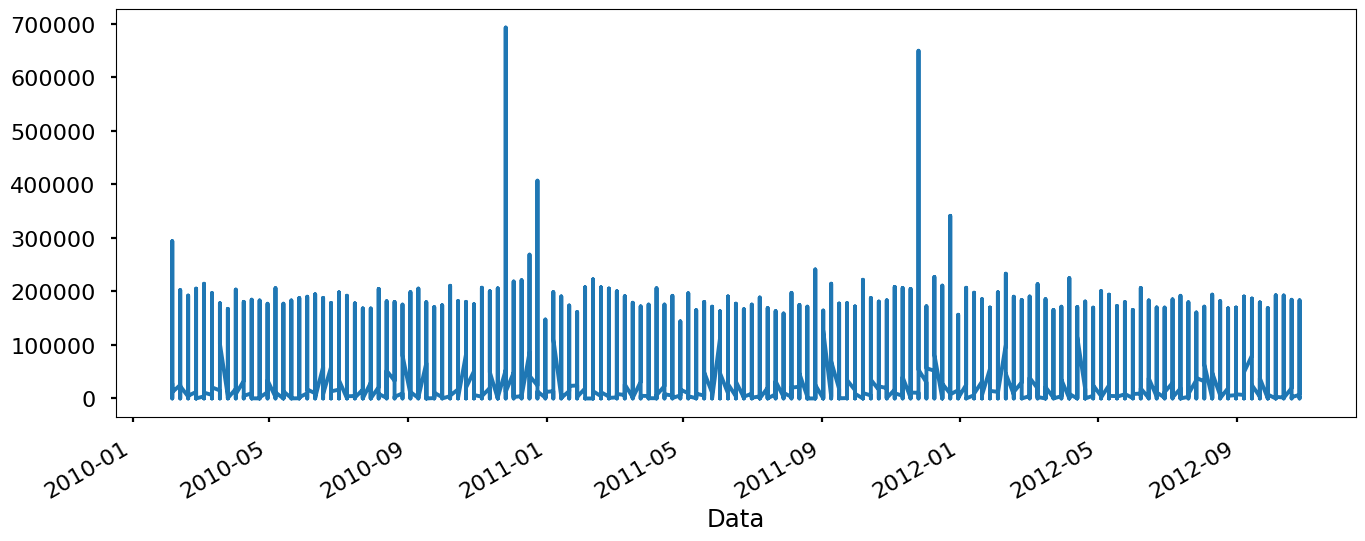

In [ ]:
df["Data"] = pd.to_datetime(df["Data"]) # Mudar data para datarime para decompor
# df.set_index('Data', inplace=True) # Define data como index

## Gráficos de Vendas ##
plt.figure(figsize=(16,6))
df['Venda_Semanal'].plot()
plt.show()

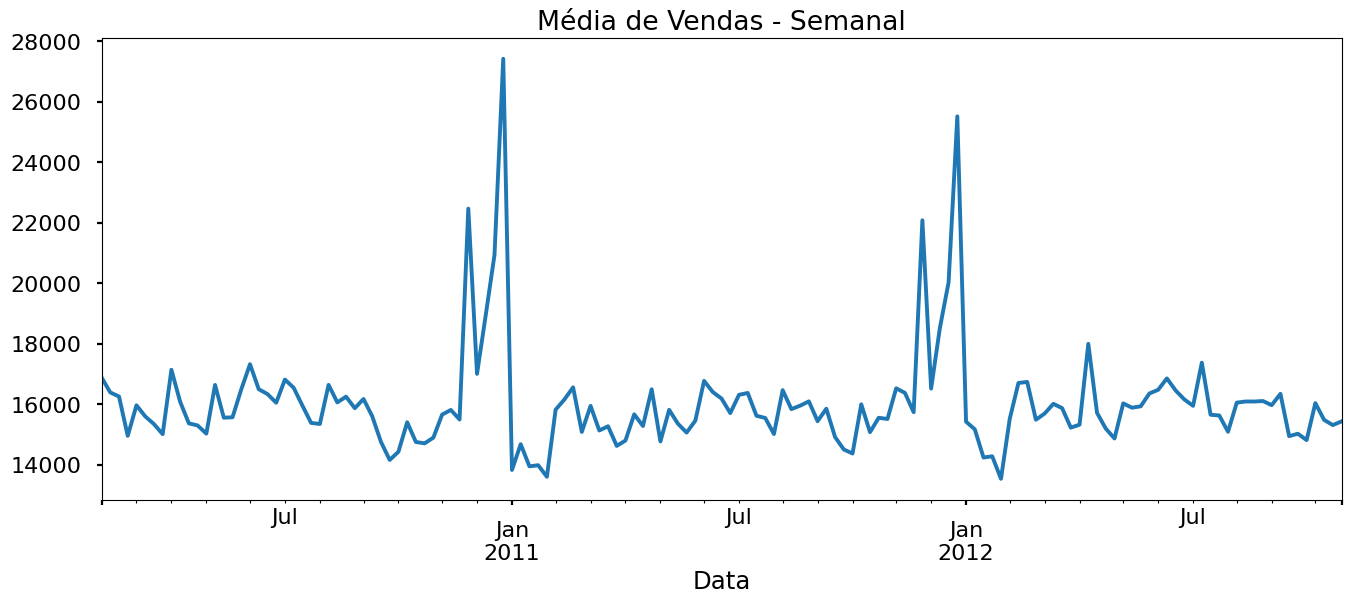

In [ ]:
# Muitos dados repetidos. Deve-se uní-los semanalmente.

df_semana = df['Venda_Semanal'].resample('W').mean()  # 'W' para semanal
plt.figure(figsize=(16, 6))
df_semana.plot()
plt.title('Média de Vendas - Semanal')
plt.show()

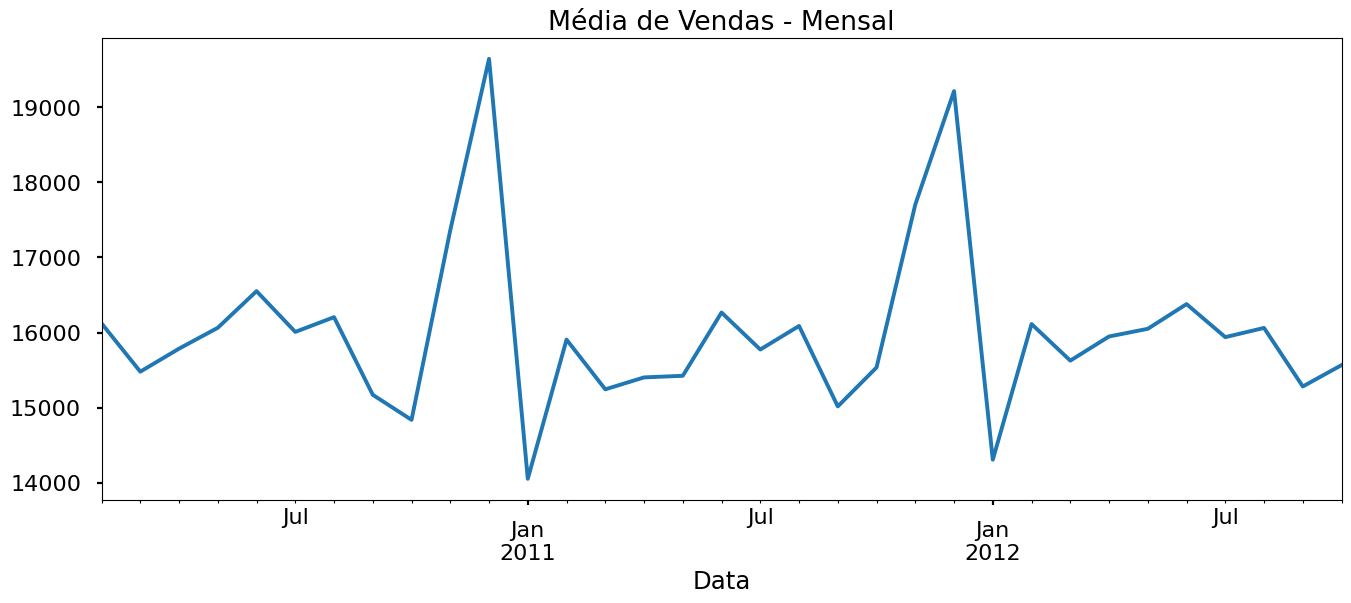

In [ ]:
# Com coleta de dados semanais, pode-se ver melhor as vendas médias.
# Para ver padrão mensal, reamostrar dados para mensais também.

df_mes = df['Venda_Semanal'].resample('MS').mean()  # 'MS' para mensal (primeiro dia do mês)
plt.figure(figsize=(16, 6))
df_mes.plot()
plt.title('Média de Vendas - Mensal')
plt.show()

In [ ]:
# Após mudar dados para mensais, perde-se certos padrões de dados semanais.
# Continuo com dados semanais reamostrados.
df_semana = df_semana.reset_index()		# Transformo index em coluna
df_semana.index = df_semana['Data']
df_semana

,Data,Venda_Semanal
Data,,
2010-02-07,2010-02-07,16887.602166
2010-02-14,2010-02-14,16390.912208
2010-02-21,2010-02-21,16255.185970
2010-02-28,2010-02-28,14955.932194
2010-03-07,2010-03-07,15964.821240
...,...,...
2012-09-30,2012-09-30,14815.621125
2012-10-07,2012-10-07,16037.442175
2012-10-14,2012-10-14,15484.696200


In [ ]:
## Observar Média Móvel e o Desvio Padrão de 2 Semanas ##
# Busco uma versão mais estacionária, pois os dados são não-estacionários
media_movel = df_semana['Venda_Semanal'].rolling(window=2, center=False).mean()
std_movel = df_semana['Venda_Semanal'].rolling(window=2, center=False).std()

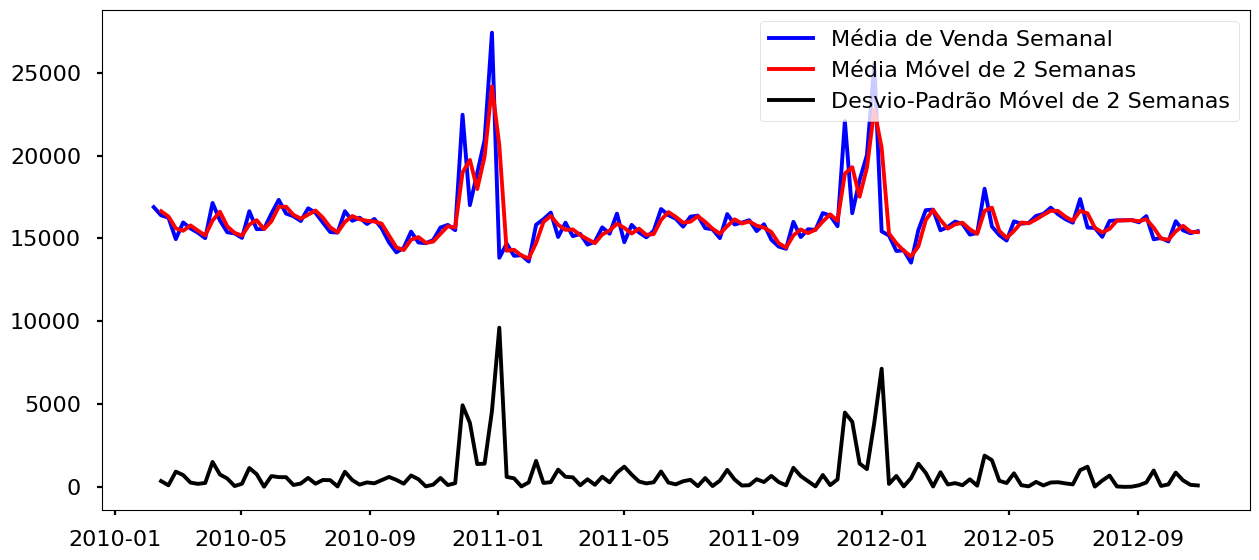

In [ ]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_semana['Venda_Semanal'], color='blue',label='Média de Venda Semanal')
ax.plot(media_movel, color='red', label='Média Móvel de 2 Semanas')
ax.plot(std_movel, color='black', label='Desvio-Padrão Móvel de 2 Semanas')
ax.legend()
fig.tight_layout()

In [ ]:
###### Teste Adfuller por garantia ######
adfuller(df_semana['Venda_Semanal'])

(-5.927107223737572,
 2.4290492082042356e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

In [ ]:
## Pelo teste os dados são estacionários (p-value < 0.05) ##
# Porém, irei colocar métodos que tornariam os dados mais estacionários, caso precise em outro dataset

In [ ]:
###### Divisão Treino-Teste de Dados Semanais ######
# Para dividir continuamente, divido manualmente, não aleatório.

dados_treino = df_semana[:int(0.7*(len(df_semana)))]
dados_teste = df_semana[int(0.7*(len(df_semana))):]

print('Treino:', dados_treino.shape)
print('Teste:', dados_teste.shape)

Treino: (100, 2)
Teste: (43, 2)


In [ ]:
alvo = "Venda_Semanal"
cols_usadas = [c for c in df_semana.columns.to_list() if c not in [alvo]] # todas colunas exceto preço

# atribuo valores treino-teste X e y

X_treino = dados_treino[cols_usadas]
X_teste = dados_teste[cols_usadas]
y_treino = dados_treino[alvo]
y_teste = dados_teste[alvo]

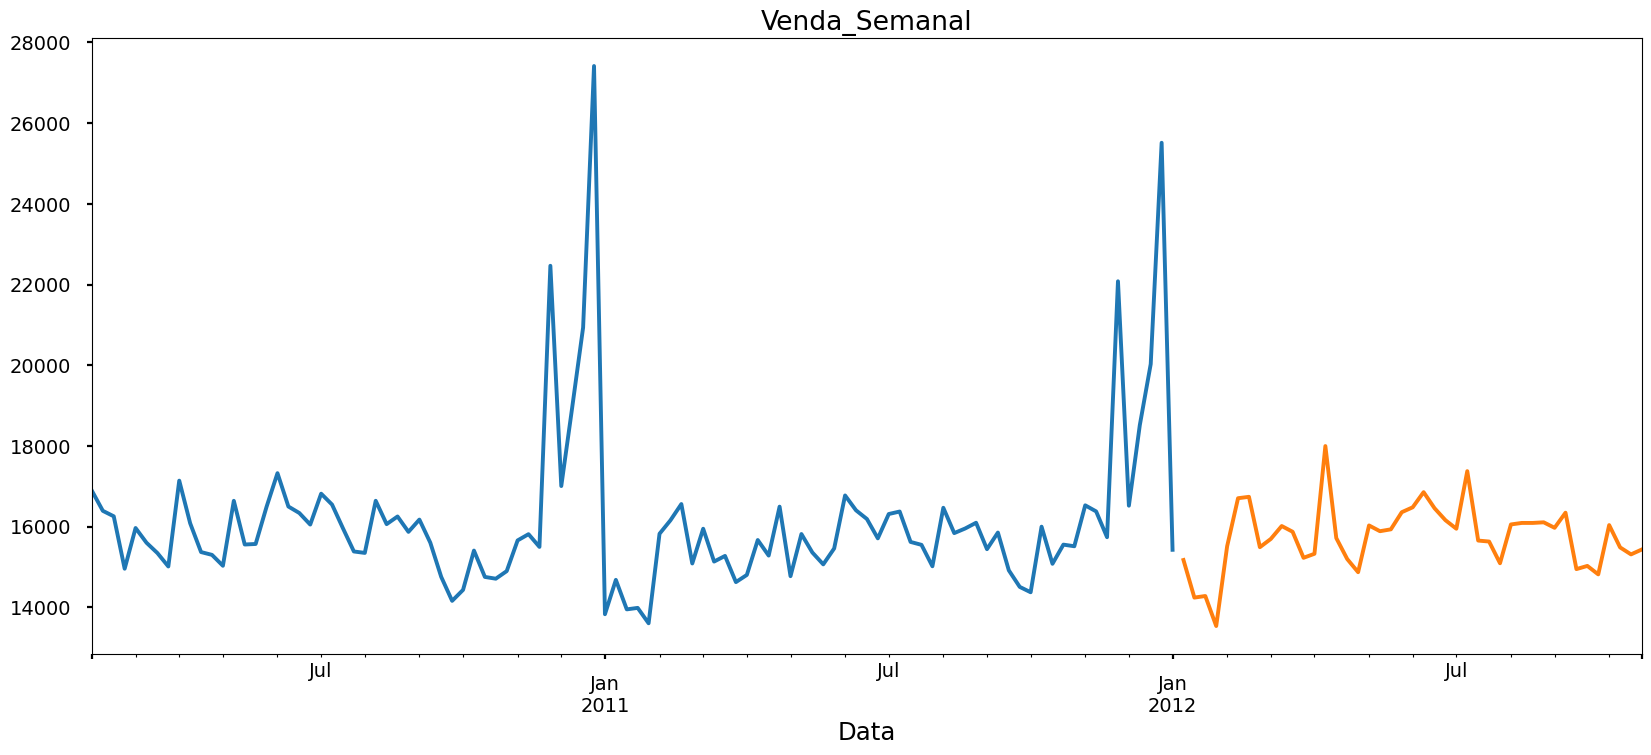

In [ ]:
dados_treino['Venda_Semanal'].plot(figsize=(20,8), title= 'Venda_Semanal', fontsize=14)
dados_teste['Venda_Semanal'].plot(figsize=(20,8), title= 'Venda_Semanal', fontsize=14)
plt.show()

In [ ]:
# Linha azul é treino, amarela é teste


###### Decompondo Dados Semanais par Observar Sazonalidade ######
decomposto = decompose(df_semana['Venda_Semanal'].values, 'additive', m=20) # decompõe dados semanais

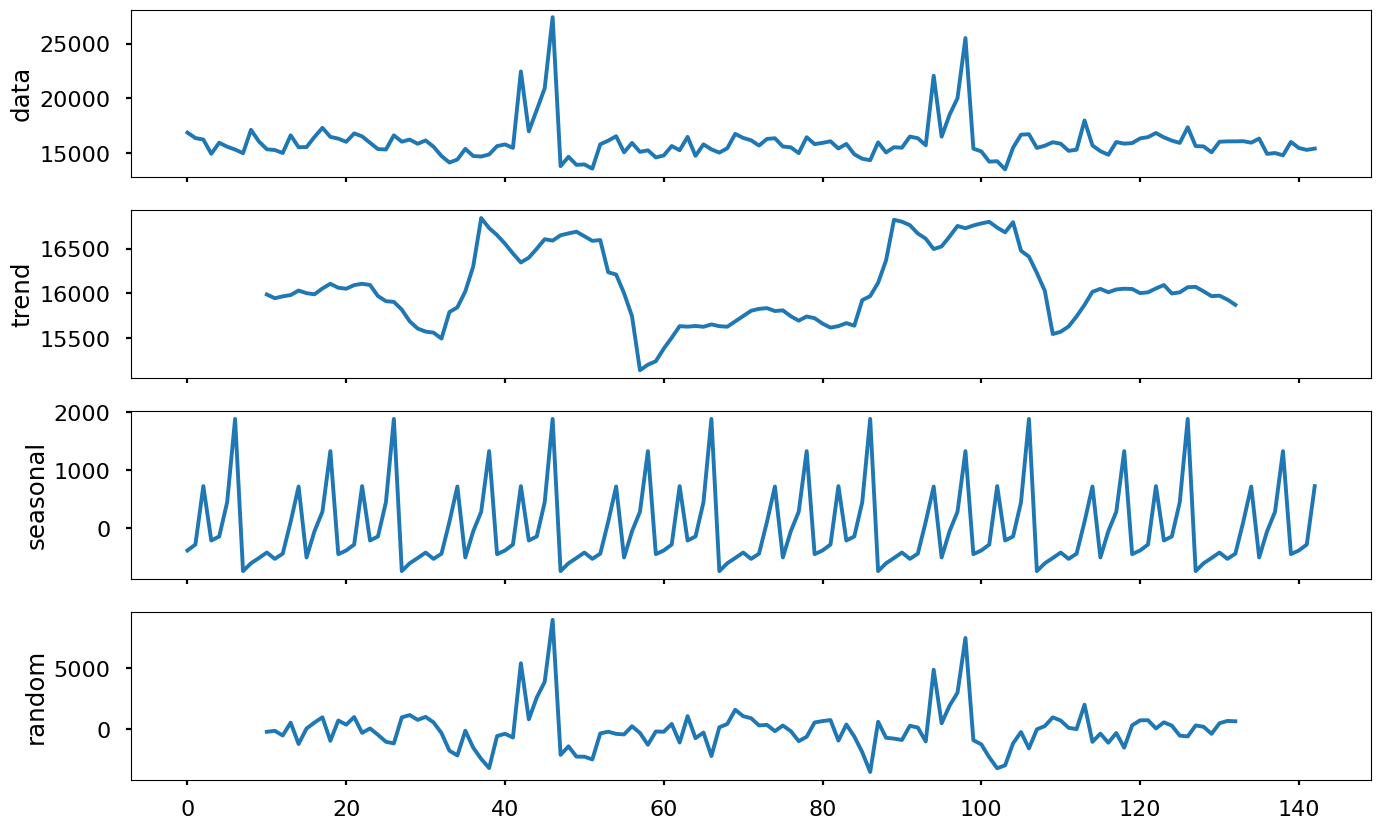

In [ ]:
decomposed_plot(decomposto, figure_kwargs={'figsize': (16, 10)})
plt.show()

In [ ]:
# A cada 20 passos, a sazonalidade converge ao início


###### Tornando Dados Mais Estacionários (APENAS PARA DEMONSTRAÇÃO) ######
# Mostrarei um modelo com dados diferenciados, registrados e deslocados

# Diferenciado
df_semana_dif = df_semana['Venda_Semanal'].diff().dropna() # cria valores de diferença

In [ ]:
# Média e Std de dados diferenciados
dif_media_movel = df_semana_dif.rolling(window=2, center=False).mean()
dif_std_movel = df_semana_dif.rolling(window=2, center=False).std()

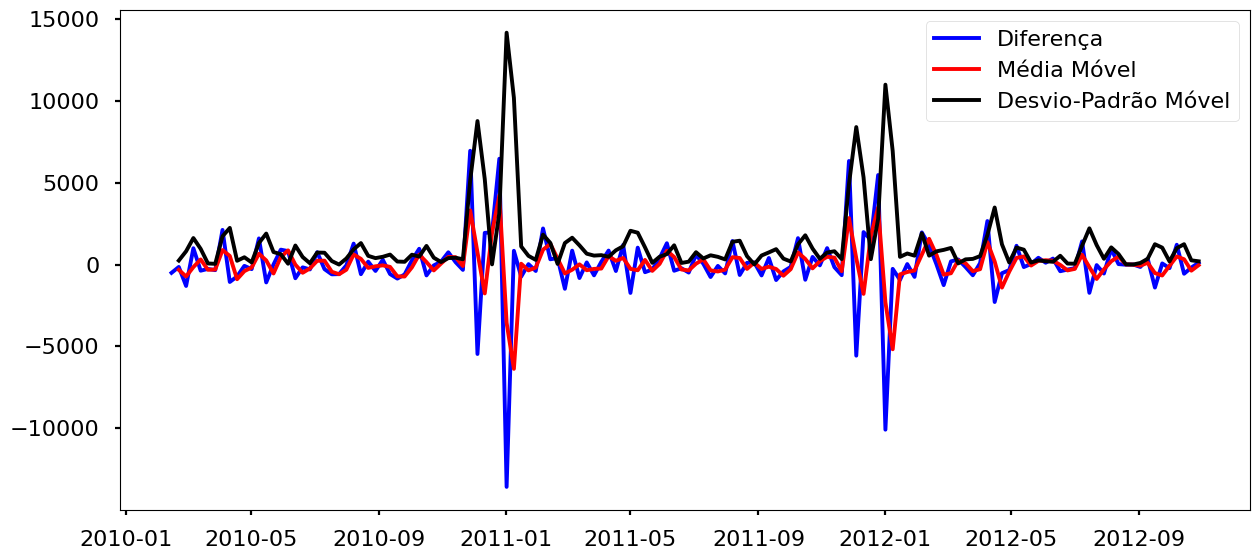

In [ ]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_semana_dif, color='blue',label='Diferença')
ax.plot(dif_media_movel, color='red', label='Média Móvel')
ax.plot(dif_std_movel, color='black', label='Desvio-Padrão Móvel')
ax.legend()
fig.tight_layout()

In [ ]:
## Deslocado
df_semana_lag = df_semana['Venda_Semanal'].shift().dropna() # desloca valores

# Média e Std de dados deslocados
lag_media_movel = df_semana_lag.rolling(window=2, center=False).mean()
lag_std_movel = df_semana_lag.rolling(window=2, center=False).std()

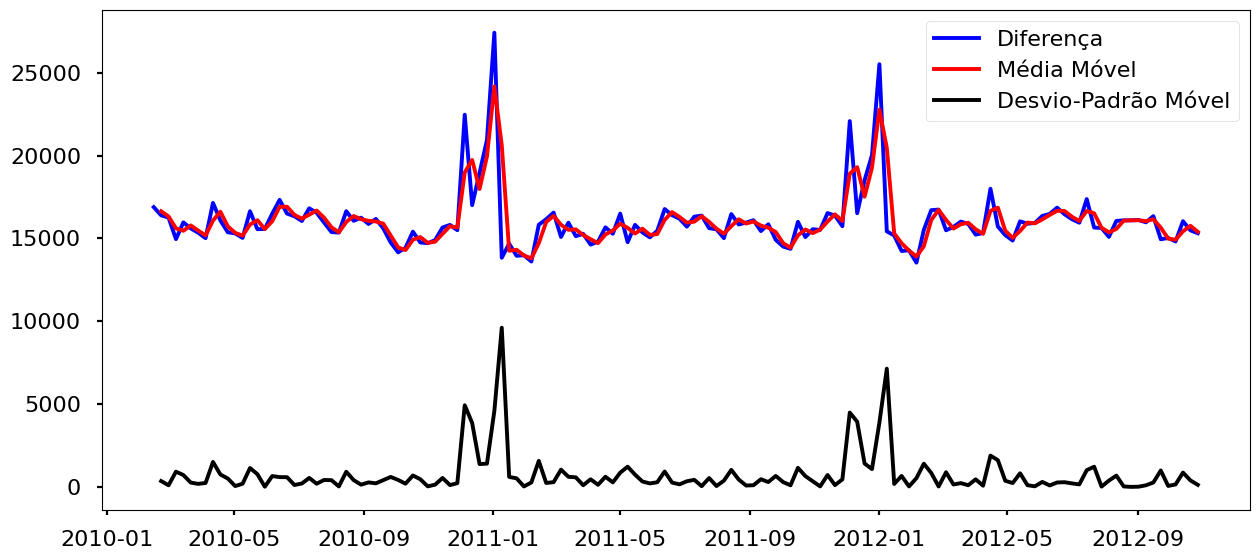

In [ ]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_semana_lag, color='blue',label='Diferença')
ax.plot(lag_media_movel, color='red', label='Média Móvel')
ax.plot(lag_std_movel, color='black', label='Desvio-Padrão Móvel')
ax.legend()
fig.tight_layout()

In [ ]:
## Registrado
semana_registrada = np.log1p(df_semana['Venda_Semanal']).dropna() # Toma registro dos dados

log_media_movel = semana_registrada.rolling(window=2, center=False).mean()
log_std_movel = semana_registrada.rolling(window=2, center=False).std()

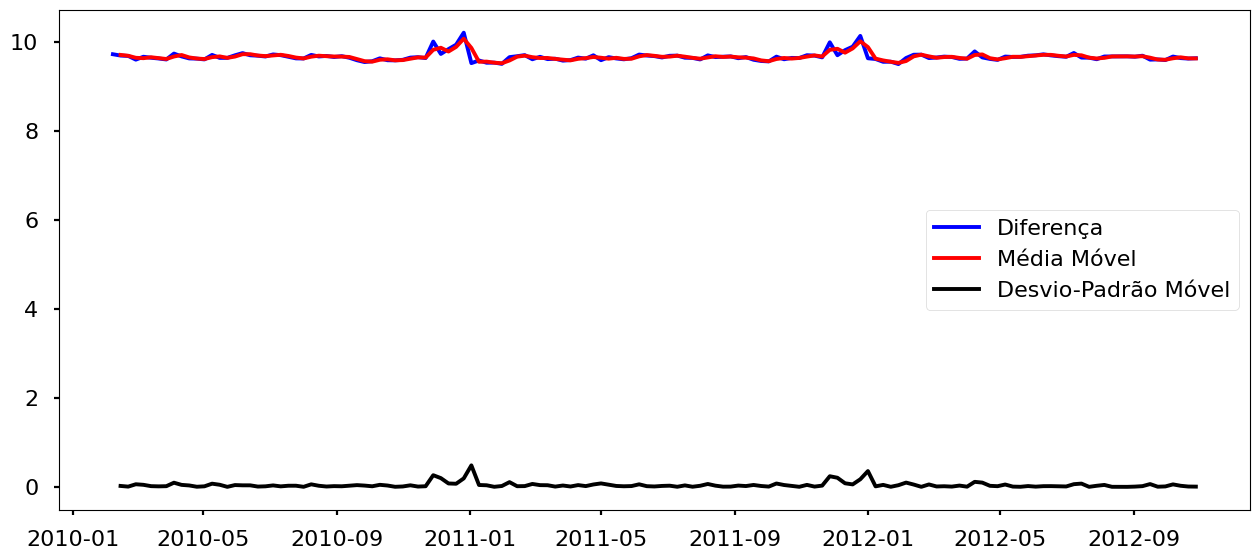

In [ ]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(semana_registrada, color='blue',label='Diferença')
ax.plot(log_media_movel, color='red', label='Média Móvel')
ax.plot(log_std_movel, color='black', label='Desvio-Padrão Móvel')
ax.legend()
fig.tight_layout()

In [ ]:
# Mostrei dados sem mudanças, depois deslocado, registrado e versão diferenciado
# Dados diferenciados foram melhores. Esses serão usados para Auto-ARIMA MODEL.



###### MODELO Auto-ARIMA ######
# Divisão Treino-Teste
dif_dados_treino = df_semana_dif [:int(0.7*(len(df_semana_dif)))]
dif_dados_teste = df_semana_dif [int(0.7*(len(df_semana_dif))):]

In [ ]:
model_auto_arima = auto_arima(dif_dados_treino, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(dif_dados_treino)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.56 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=2.26 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.22 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

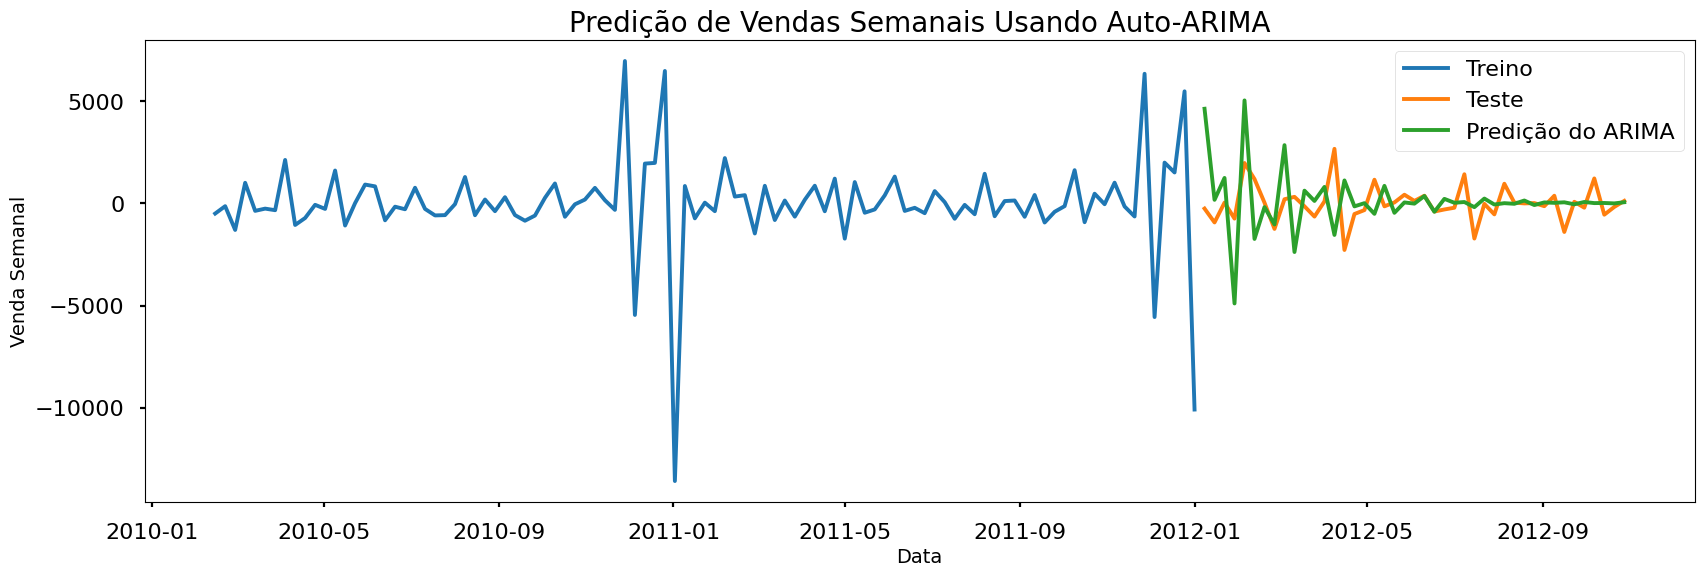

In [ ]:
y_pred = model_auto_arima.predict(n_periods=len(dif_dados_teste))
y_pred = pd.DataFrame(y_pred,index = dados_teste.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Predição de Vendas Semanais Usando Auto-ARIMA', fontsize=20)
plt.plot(dif_dados_treino, label='Treino')
plt.plot(dif_dados_teste, label='Teste')
plt.plot(y_pred, label='Predição do ARIMA')
plt.legend(loc='best')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Venda Semanal', fontsize=14)
plt.show()

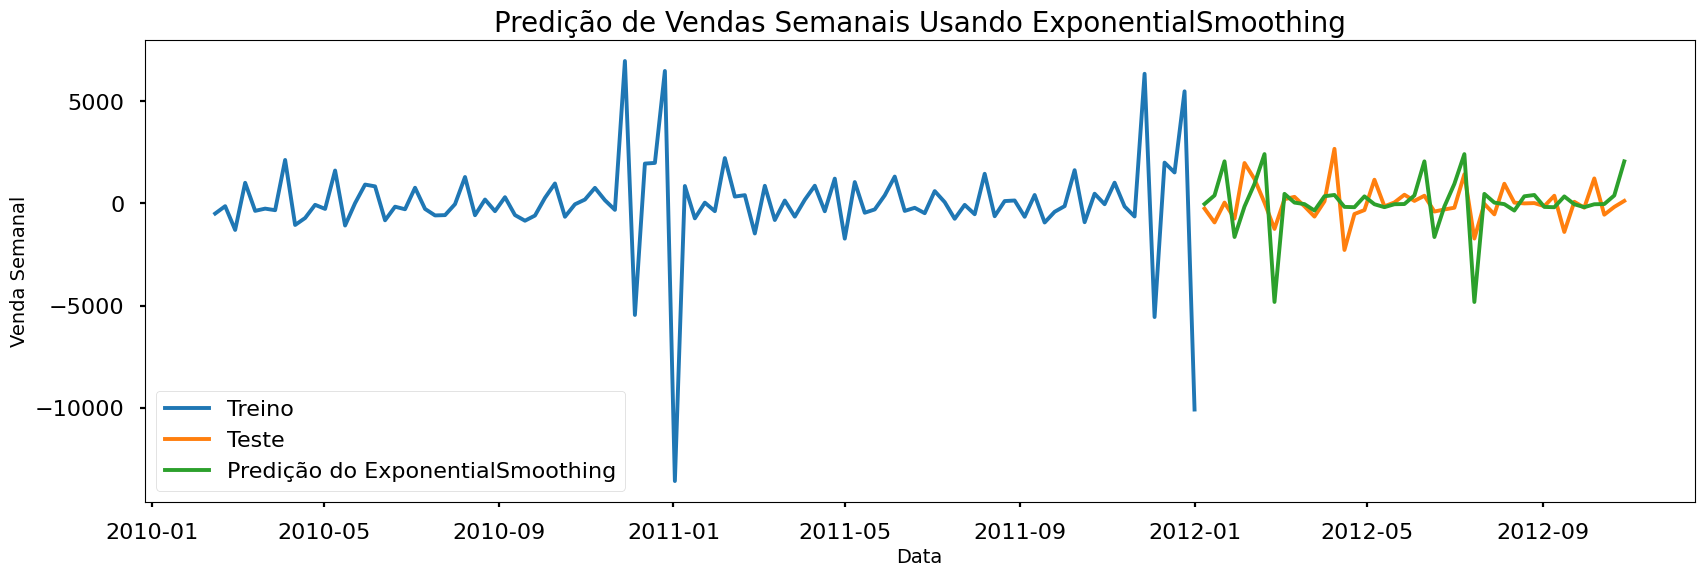

In [ ]:
# Caso tente outro Modelo

###### MODELO ExponentialSmoothing ######
# Verifico modelos Holt-Winters de acordo com dados.
# Exponential Smooting é usado quando os dados tem tendência, e achata a tendência.
# Método de tendência amortecida adiciona um parâmetro de amortecimento para que a tendência convirja para um valor constante no futuro.

# Os dados têm certos valores negativos e zero, uso sazonal aditivo e tendência em vez do multiplicativo.
# Períodos sazonais escolhidos a partir dos gráficos compostos acima.
# Ajustar modelo com iterações toma muito tempo, mudo e experimento modelo
# para diferentes parâmetros, encontro os melhores e ajusto modelo.

model_holt_winters = ExponentialSmoothing(dif_dados_treino, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Tendência e sazonalidade aditiva.
y_pred = model_holt_winters.forecast(len(dif_dados_teste))# Prediz valores de teste

# Visualiza treino, teste e dados preditos.
plt.figure(figsize=(20,6))
plt.title('Predição de Vendas Semanais Usando ExponentialSmoothing', fontsize=20)
plt.plot(dif_dados_treino, label='Treino')
plt.plot(dif_dados_teste, label='Teste')
plt.plot(y_pred, label='Predição do ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Venda Semanal', fontsize=14)
plt.show()